In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\SKS\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Exploratory Data Analysis

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:/Users/SKS/Desktop/AAIC/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [7]:
final['Time']=pd.to_datetime(final['Time'])
final=final.sort_values(by='Time',ascending=True)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1970-01-01 00:00:00.939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1970-01-01 00:00:00.940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1970-01-01 00:00:00.944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1970-01-01 00:00:00.944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,1970-01-01 00:00:00.946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [8]:
final=final.iloc[:100000,:]

#   Preprocessing

In [9]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:33<00:00, 3001.37it/s]


In [11]:
# Creating a Dictionary with Unique Words of reviews and its count
vocab={}
for sent in tqdm(preprocessed_reviews):
    for i in sent.split(' '):
        if i not in vocab:
            vocab[i]=1
        else:
            vocab[i]+=1
    

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 44355.71it/s]


In [12]:
# Sorting the Dictionary with Most Frequent Word at the Top
sorted_vocab = sorted(vocab.items(), key=lambda kv: kv[1],reverse = True)

In [13]:
# Taking only Top 5000 Words 
import itertools
sorted_vocab = dict(itertools.islice(sorted_vocab, 0, 5000))

In [14]:
# Assigning words there rank occording to its frequency
ranked_vocab={}
k=1
for i in tqdm(sorted_vocab):
    ranked_vocab[i]=k
    k=k+1

100%|██████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 499571.69it/s]


In [15]:
# Converting Reviews into Vectors according to Frequency Rank
vectors=[]
for sent in tqdm(preprocessed_reviews):
    sentence=[]
    for i in sent.split():
        if i in ranked_vocab:
            sentence.append(ranked_vocab[i])
        else:
            sentence.append(0)
    vectors.append(sentence)
        

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 37926.25it/s]


In [16]:
len(vectors)

100000

In [17]:
len(vectors[1])

75

In [18]:
print(vectors[1])

[2, 31, 768, 2094, 1, 1586, 57, 7, 0, 21, 0, 144, 394, 57, 2, 20, 4, 1014, 70, 1444, 682, 125, 52, 1, 0, 88, 2, 13, 6, 12, 136, 2, 48, 0, 177, 2, 108, 12, 4805, 8, 3182, 0, 57, 2, 103, 18, 4332, 0, 11, 0, 852, 1, 211, 1105, 21, 6, 7, 2, 48, 114, 855, 7, 21, 0, 631, 17, 1, 3182, 11, 18, 801, 24, 3519, 2299, 21]


In [19]:
len(ranked_vocab.keys())

5000

In [20]:
score=final.Score.values
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(vectors,score,test_size=0.30,shuffle=False)

In [21]:
print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[2, 31, 768, 2094, 1, 1586, 57, 7, 0, 21, 0, 144, 394, 57, 2, 20, 4, 1014, 70, 1444, 682, 125, 52, 1, 0, 88, 2, 13, 6, 12, 136, 2, 48, 0, 177, 2, 108, 12, 4805, 8, 3182, 0, 57, 2, 103, 18, 4332, 0, 11, 0, 852, 1, 211, 1105, 21, 6, 7, 2, 48, 114, 855, 7, 21, 0, 631, 17, 1, 3182, 11, 18, 801, 24, 3519, 2299, 21]
<class 'list'>
75


In [22]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)


Using TensorFlow backend.


In [23]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[1])

(70000, 600)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

## RNN Model with 1 LSTM and 1 Dropout

In [24]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,333
Trainable params: 213,333
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 70000 samples, validate on 30000 samples
Epoch 1/10


13056/70000 [====>.........................] - ETA: 1:09:25 - loss: 0.6929 - acc: 0.54 - ETA: 41:49 - loss: 0.6897 - acc: 0.7266 - ETA: 32:31 - loss: 0.6866 - acc: 0.77 - ETA: 27:53 - loss: 0.6820 - acc: 0.82 - ETA: 25:09 - loss: 0.6781 - acc: 0.84 - ETA: 23:47 - loss: 0.6747 - acc: 0.84 - ETA: 22:34 - loss: 0.6682 - acc: 0.85 - ETA: 21:32 - loss: 0.6615 - acc: 0.86 - ETA: 20:40 - loss: 0.6542 - acc: 0.86 - ETA: 19:59 - loss: 0.6462 - acc: 0.86 - ETA: 19:24 - loss: 0.6358 - acc: 0.86 - ETA: 18:57 - loss: 0.6131 - acc: 0.86 - ETA: 18:46 - loss: 0.5895 - acc: 0.87 - ETA: 18:34 - loss: 0.5851 - acc: 0.87 - ETA: 18:14 - loss: 0.5819 - acc: 0.87 - ETA: 17:58 - loss: 0.5700 - acc: 0.87 - ETA: 17:43 - loss: 0.5581 - acc: 0.87 - ETA: 17:29 - loss: 0.5465 - acc: 0.87 - ETA: 17:37 - loss: 0.5339 - acc: 0.87 - ETA: 17:30 - loss: 0.5288 - acc: 0.87 - ETA: 17:20 - loss: 0.5198 - acc: 0.87 - ETA: 17:09 - loss: 0.5152 - acc: 0.87 - ETA: 17:00 - loss: 0.5100 - acc: 0.87 - ETA: 16:51 - loss: 0.5086 - a

52224/70000 [=====================>........] - ETA: 6:40 - loss: 0.2683 - acc: 0.901 - ETA: 6:39 - loss: 0.2682 - acc: 0.901 - ETA: 6:38 - loss: 0.2679 - acc: 0.901 - ETA: 6:37 - loss: 0.2678 - acc: 0.901 - ETA: 6:37 - loss: 0.2676 - acc: 0.901 - ETA: 6:36 - loss: 0.2674 - acc: 0.901 - ETA: 6:35 - loss: 0.2671 - acc: 0.901 - ETA: 6:34 - loss: 0.2669 - acc: 0.901 - ETA: 6:33 - loss: 0.2669 - acc: 0.901 - ETA: 6:32 - loss: 0.2668 - acc: 0.901 - ETA: 6:32 - loss: 0.2670 - acc: 0.901 - ETA: 6:31 - loss: 0.2669 - acc: 0.901 - ETA: 6:30 - loss: 0.2667 - acc: 0.901 - ETA: 6:29 - loss: 0.2665 - acc: 0.901 - ETA: 6:28 - loss: 0.2664 - acc: 0.902 - ETA: 6:27 - loss: 0.2662 - acc: 0.902 - ETA: 6:27 - loss: 0.2661 - acc: 0.902 - ETA: 6:26 - loss: 0.2659 - acc: 0.902 - ETA: 6:25 - loss: 0.2657 - acc: 0.902 - ETA: 6:24 - loss: 0.2655 - acc: 0.902 - ETA: 6:23 - loss: 0.2653 - acc: 0.902 - ETA: 6:22 - loss: 0.2651 - acc: 0.902 - ETA: 6:22 - loss: 0.2653 - acc: 0.902 - ETA: 6:21 - loss: 0.2652 - acc: 0

65280/70000 [==========================>...] - ETA: 3:50 - loss: 0.2503 - acc: 0.907 - ETA: 3:49 - loss: 0.2502 - acc: 0.907 - ETA: 3:48 - loss: 0.2502 - acc: 0.907 - ETA: 3:48 - loss: 0.2500 - acc: 0.907 - ETA: 3:47 - loss: 0.2501 - acc: 0.907 - ETA: 3:46 - loss: 0.2501 - acc: 0.907 - ETA: 3:45 - loss: 0.2499 - acc: 0.907 - ETA: 3:44 - loss: 0.2497 - acc: 0.907 - ETA: 3:43 - loss: 0.2497 - acc: 0.907 - ETA: 3:43 - loss: 0.2496 - acc: 0.907 - ETA: 3:42 - loss: 0.2494 - acc: 0.907 - ETA: 3:41 - loss: 0.2493 - acc: 0.907 - ETA: 3:40 - loss: 0.2491 - acc: 0.907 - ETA: 3:39 - loss: 0.2491 - acc: 0.907 - ETA: 3:38 - loss: 0.2490 - acc: 0.907 - ETA: 3:38 - loss: 0.2489 - acc: 0.907 - ETA: 3:37 - loss: 0.2488 - acc: 0.907 - ETA: 3:36 - loss: 0.2487 - acc: 0.907 - ETA: 3:35 - loss: 0.2488 - acc: 0.907 - ETA: 3:34 - loss: 0.2486 - acc: 0.907 - ETA: 3:33 - loss: 0.2484 - acc: 0.907 - ETA: 3:33 - loss: 0.2483 - acc: 0.908 - ETA: 3:32 - loss: 0.2483 - acc: 0.908 - ETA: 3:31 - loss: 0.2483 - acc: 0

70000/70000 [==============================] - ETA: 1:00 - loss: 0.2420 - acc: 0.909 - ETA: 59s - loss: 0.2419 - acc: 0.909 - ETA: 58s - loss: 0.2418 - acc: 0.90 - ETA: 58s - loss: 0.2418 - acc: 0.90 - ETA: 57s - loss: 0.2418 - acc: 0.90 - ETA: 56s - loss: 0.2417 - acc: 0.90 - ETA: 55s - loss: 0.2416 - acc: 0.90 - ETA: 54s - loss: 0.2416 - acc: 0.90 - ETA: 53s - loss: 0.2417 - acc: 0.90 - ETA: 53s - loss: 0.2416 - acc: 0.90 - ETA: 52s - loss: 0.2415 - acc: 0.90 - ETA: 51s - loss: 0.2414 - acc: 0.90 - ETA: 50s - loss: 0.2414 - acc: 0.90 - ETA: 49s - loss: 0.2412 - acc: 0.90 - ETA: 48s - loss: 0.2411 - acc: 0.90 - ETA: 48s - loss: 0.2411 - acc: 0.91 - ETA: 47s - loss: 0.2410 - acc: 0.91 - ETA: 46s - loss: 0.2410 - acc: 0.91 - ETA: 45s - loss: 0.2410 - acc: 0.90 - ETA: 44s - loss: 0.2409 - acc: 0.91 - ETA: 43s - loss: 0.2408 - acc: 0.91 - ETA: 43s - loss: 0.2409 - acc: 0.91 - ETA: 42s - loss: 0.2408 - acc: 0.91 - ETA: 41s - loss: 0.2408 - acc: 0.91 - ETA: 40s - loss: 0.2407 - acc: 0.91 - 

13056/70000 [====>.........................] - ETA: 14:16 - loss: 0.2397 - acc: 0.90 - ETA: 14:14 - loss: 0.1885 - acc: 0.92 - ETA: 14:46 - loss: 0.1802 - acc: 0.91 - ETA: 14:40 - loss: 0.1911 - acc: 0.91 - ETA: 15:10 - loss: 0.1753 - acc: 0.92 - ETA: 14:58 - loss: 0.1660 - acc: 0.92 - ETA: 14:52 - loss: 0.1570 - acc: 0.93 - ETA: 14:45 - loss: 0.1523 - acc: 0.93 - ETA: 14:41 - loss: 0.1504 - acc: 0.94 - ETA: 14:47 - loss: 0.1445 - acc: 0.94 - ETA: 15:01 - loss: 0.1463 - acc: 0.94 - ETA: 14:55 - loss: 0.1558 - acc: 0.93 - ETA: 14:52 - loss: 0.1550 - acc: 0.93 - ETA: 14:48 - loss: 0.1510 - acc: 0.93 - ETA: 14:44 - loss: 0.1511 - acc: 0.93 - ETA: 14:47 - loss: 0.1521 - acc: 0.93 - ETA: 14:46 - loss: 0.1563 - acc: 0.93 - ETA: 14:51 - loss: 0.1554 - acc: 0.93 - ETA: 14:47 - loss: 0.1567 - acc: 0.93 - ETA: 14:45 - loss: 0.1558 - acc: 0.93 - ETA: 14:42 - loss: 0.1559 - acc: 0.93 - ETA: 14:44 - loss: 0.1576 - acc: 0.93 - ETA: 14:44 - loss: 0.1574 - acc: 0.93 - ETA: 14:51 - loss: 0.1606 - acc: 

52224/70000 [=====================>........] - ETA: 6:39 - loss: 0.1689 - acc: 0.937 - ETA: 6:38 - loss: 0.1689 - acc: 0.937 - ETA: 6:37 - loss: 0.1689 - acc: 0.937 - ETA: 6:37 - loss: 0.1688 - acc: 0.937 - ETA: 6:36 - loss: 0.1688 - acc: 0.937 - ETA: 6:35 - loss: 0.1688 - acc: 0.937 - ETA: 6:34 - loss: 0.1687 - acc: 0.937 - ETA: 6:33 - loss: 0.1689 - acc: 0.937 - ETA: 6:32 - loss: 0.1689 - acc: 0.937 - ETA: 6:32 - loss: 0.1688 - acc: 0.937 - ETA: 6:31 - loss: 0.1689 - acc: 0.937 - ETA: 6:30 - loss: 0.1689 - acc: 0.937 - ETA: 6:29 - loss: 0.1688 - acc: 0.937 - ETA: 6:28 - loss: 0.1688 - acc: 0.937 - ETA: 6:27 - loss: 0.1688 - acc: 0.937 - ETA: 6:27 - loss: 0.1688 - acc: 0.937 - ETA: 6:26 - loss: 0.1688 - acc: 0.938 - ETA: 6:25 - loss: 0.1688 - acc: 0.937 - ETA: 6:24 - loss: 0.1689 - acc: 0.937 - ETA: 6:23 - loss: 0.1690 - acc: 0.937 - ETA: 6:22 - loss: 0.1690 - acc: 0.937 - ETA: 6:22 - loss: 0.1691 - acc: 0.937 - ETA: 6:21 - loss: 0.1690 - acc: 0.937 - ETA: 6:20 - loss: 0.1689 - acc: 0

65280/70000 [==========================>...] - ETA: 3:49 - loss: 0.1679 - acc: 0.938 - ETA: 3:48 - loss: 0.1680 - acc: 0.938 - ETA: 3:48 - loss: 0.1678 - acc: 0.938 - ETA: 3:47 - loss: 0.1677 - acc: 0.938 - ETA: 3:46 - loss: 0.1679 - acc: 0.938 - ETA: 3:45 - loss: 0.1681 - acc: 0.938 - ETA: 3:44 - loss: 0.1683 - acc: 0.938 - ETA: 3:43 - loss: 0.1682 - acc: 0.938 - ETA: 3:43 - loss: 0.1681 - acc: 0.938 - ETA: 3:42 - loss: 0.1682 - acc: 0.938 - ETA: 3:41 - loss: 0.1682 - acc: 0.938 - ETA: 3:40 - loss: 0.1683 - acc: 0.938 - ETA: 3:39 - loss: 0.1684 - acc: 0.938 - ETA: 3:38 - loss: 0.1685 - acc: 0.938 - ETA: 3:38 - loss: 0.1684 - acc: 0.938 - ETA: 3:37 - loss: 0.1685 - acc: 0.938 - ETA: 3:36 - loss: 0.1685 - acc: 0.938 - ETA: 3:35 - loss: 0.1684 - acc: 0.938 - ETA: 3:34 - loss: 0.1684 - acc: 0.938 - ETA: 3:33 - loss: 0.1684 - acc: 0.938 - ETA: 3:33 - loss: 0.1685 - acc: 0.938 - ETA: 3:32 - loss: 0.1685 - acc: 0.938 - ETA: 3:31 - loss: 0.1686 - acc: 0.938 - ETA: 3:30 - loss: 0.1685 - acc: 0

70000/70000 [==============================] - ETA: 1:00 - loss: 0.1691 - acc: 0.937 - ETA: 59s - loss: 0.1691 - acc: 0.937 - ETA: 58s - loss: 0.1691 - acc: 0.93 - ETA: 57s - loss: 0.1690 - acc: 0.93 - ETA: 56s - loss: 0.1690 - acc: 0.93 - ETA: 56s - loss: 0.1689 - acc: 0.93 - ETA: 55s - loss: 0.1689 - acc: 0.93 - ETA: 54s - loss: 0.1689 - acc: 0.93 - ETA: 53s - loss: 0.1689 - acc: 0.93 - ETA: 52s - loss: 0.1688 - acc: 0.93 - ETA: 51s - loss: 0.1688 - acc: 0.93 - ETA: 51s - loss: 0.1689 - acc: 0.93 - ETA: 50s - loss: 0.1689 - acc: 0.93 - ETA: 49s - loss: 0.1688 - acc: 0.93 - ETA: 48s - loss: 0.1689 - acc: 0.93 - ETA: 47s - loss: 0.1690 - acc: 0.93 - ETA: 47s - loss: 0.1690 - acc: 0.93 - ETA: 46s - loss: 0.1689 - acc: 0.93 - ETA: 45s - loss: 0.1689 - acc: 0.93 - ETA: 44s - loss: 0.1688 - acc: 0.93 - ETA: 43s - loss: 0.1689 - acc: 0.93 - ETA: 42s - loss: 0.1689 - acc: 0.93 - ETA: 42s - loss: 0.1688 - acc: 0.93 - ETA: 41s - loss: 0.1688 - acc: 0.93 - ETA: 40s - loss: 0.1689 - acc: 0.93 - 

13056/70000 [====>.........................] - ETA: 14:19 - loss: 0.1877 - acc: 0.90 - ETA: 14:11 - loss: 0.1318 - acc: 0.93 - ETA: 15:23 - loss: 0.1356 - acc: 0.94 - ETA: 15:07 - loss: 0.1444 - acc: 0.94 - ETA: 14:55 - loss: 0.1356 - acc: 0.95 - ETA: 15:06 - loss: 0.1310 - acc: 0.94 - ETA: 14:56 - loss: 0.1240 - acc: 0.94 - ETA: 14:50 - loss: 0.1332 - acc: 0.94 - ETA: 15:05 - loss: 0.1237 - acc: 0.94 - ETA: 14:58 - loss: 0.1365 - acc: 0.94 - ETA: 14:51 - loss: 0.1507 - acc: 0.94 - ETA: 14:57 - loss: 0.1562 - acc: 0.94 - ETA: 14:52 - loss: 0.1551 - acc: 0.94 - ETA: 14:48 - loss: 0.1547 - acc: 0.94 - ETA: 14:44 - loss: 0.1511 - acc: 0.94 - ETA: 14:53 - loss: 0.1521 - acc: 0.94 - ETA: 14:50 - loss: 0.1478 - acc: 0.94 - ETA: 14:47 - loss: 0.1420 - acc: 0.95 - ETA: 14:48 - loss: 0.1390 - acc: 0.95 - ETA: 14:45 - loss: 0.1371 - acc: 0.95 - ETA: 14:42 - loss: 0.1340 - acc: 0.95 - ETA: 14:48 - loss: 0.1439 - acc: 0.94 - ETA: 14:45 - loss: 0.1410 - acc: 0.94 - ETA: 14:42 - loss: 0.1398 - acc: 

52224/70000 [=====================>........] - ETA: 6:37 - loss: 0.1442 - acc: 0.946 - ETA: 6:36 - loss: 0.1441 - acc: 0.946 - ETA: 6:35 - loss: 0.1442 - acc: 0.946 - ETA: 6:34 - loss: 0.1440 - acc: 0.946 - ETA: 6:33 - loss: 0.1440 - acc: 0.946 - ETA: 6:32 - loss: 0.1440 - acc: 0.946 - ETA: 6:32 - loss: 0.1440 - acc: 0.946 - ETA: 6:31 - loss: 0.1440 - acc: 0.946 - ETA: 6:30 - loss: 0.1440 - acc: 0.946 - ETA: 6:29 - loss: 0.1440 - acc: 0.946 - ETA: 6:28 - loss: 0.1439 - acc: 0.946 - ETA: 6:27 - loss: 0.1439 - acc: 0.946 - ETA: 6:27 - loss: 0.1439 - acc: 0.946 - ETA: 6:26 - loss: 0.1440 - acc: 0.946 - ETA: 6:25 - loss: 0.1439 - acc: 0.946 - ETA: 6:24 - loss: 0.1439 - acc: 0.946 - ETA: 6:23 - loss: 0.1442 - acc: 0.946 - ETA: 6:22 - loss: 0.1441 - acc: 0.946 - ETA: 6:22 - loss: 0.1441 - acc: 0.946 - ETA: 6:21 - loss: 0.1441 - acc: 0.946 - ETA: 6:20 - loss: 0.1441 - acc: 0.946 - ETA: 6:19 - loss: 0.1440 - acc: 0.946 - ETA: 6:18 - loss: 0.1440 - acc: 0.946 - ETA: 6:17 - loss: 0.1442 - acc: 0

65280/70000 [==========================>...] - ETA: 3:48 - loss: 0.1452 - acc: 0.946 - ETA: 3:47 - loss: 0.1453 - acc: 0.945 - ETA: 3:46 - loss: 0.1457 - acc: 0.945 - ETA: 3:45 - loss: 0.1457 - acc: 0.945 - ETA: 3:45 - loss: 0.1457 - acc: 0.945 - ETA: 3:44 - loss: 0.1458 - acc: 0.945 - ETA: 3:43 - loss: 0.1458 - acc: 0.945 - ETA: 3:42 - loss: 0.1458 - acc: 0.945 - ETA: 3:41 - loss: 0.1458 - acc: 0.945 - ETA: 3:41 - loss: 0.1459 - acc: 0.945 - ETA: 3:40 - loss: 0.1460 - acc: 0.945 - ETA: 3:39 - loss: 0.1461 - acc: 0.945 - ETA: 3:38 - loss: 0.1461 - acc: 0.945 - ETA: 3:37 - loss: 0.1461 - acc: 0.945 - ETA: 3:36 - loss: 0.1461 - acc: 0.945 - ETA: 3:36 - loss: 0.1462 - acc: 0.945 - ETA: 3:35 - loss: 0.1461 - acc: 0.945 - ETA: 3:34 - loss: 0.1460 - acc: 0.945 - ETA: 3:33 - loss: 0.1460 - acc: 0.945 - ETA: 3:32 - loss: 0.1459 - acc: 0.945 - ETA: 3:31 - loss: 0.1460 - acc: 0.945 - ETA: 3:31 - loss: 0.1461 - acc: 0.945 - ETA: 3:30 - loss: 0.1462 - acc: 0.945 - ETA: 3:29 - loss: 0.1462 - acc: 0

70000/70000 [==============================] - ETA: 1:00 - loss: 0.1463 - acc: 0.945 - ETA: 59s - loss: 0.1464 - acc: 0.945 - ETA: 58s - loss: 0.1465 - acc: 0.94 - ETA: 57s - loss: 0.1464 - acc: 0.94 - ETA: 56s - loss: 0.1464 - acc: 0.94 - ETA: 55s - loss: 0.1465 - acc: 0.94 - ETA: 55s - loss: 0.1465 - acc: 0.94 - ETA: 54s - loss: 0.1465 - acc: 0.94 - ETA: 53s - loss: 0.1465 - acc: 0.94 - ETA: 52s - loss: 0.1465 - acc: 0.94 - ETA: 51s - loss: 0.1465 - acc: 0.94 - ETA: 51s - loss: 0.1466 - acc: 0.94 - ETA: 50s - loss: 0.1466 - acc: 0.94 - ETA: 49s - loss: 0.1466 - acc: 0.94 - ETA: 48s - loss: 0.1466 - acc: 0.94 - ETA: 47s - loss: 0.1466 - acc: 0.94 - ETA: 46s - loss: 0.1465 - acc: 0.94 - ETA: 46s - loss: 0.1465 - acc: 0.94 - ETA: 45s - loss: 0.1465 - acc: 0.94 - ETA: 44s - loss: 0.1466 - acc: 0.94 - ETA: 43s - loss: 0.1466 - acc: 0.94 - ETA: 42s - loss: 0.1465 - acc: 0.94 - ETA: 41s - loss: 0.1465 - acc: 0.94 - ETA: 41s - loss: 0.1466 - acc: 0.94 - ETA: 40s - loss: 0.1465 - acc: 0.94 - 

13056/70000 [====>.........................] - ETA: 14:12 - loss: 0.1914 - acc: 0.93 - ETA: 14:13 - loss: 0.1724 - acc: 0.94 - ETA: 14:10 - loss: 0.1497 - acc: 0.94 - ETA: 14:15 - loss: 0.1645 - acc: 0.94 - ETA: 14:36 - loss: 0.1426 - acc: 0.95 - ETA: 15:03 - loss: 0.1330 - acc: 0.95 - ETA: 14:54 - loss: 0.1243 - acc: 0.95 - ETA: 14:48 - loss: 0.1202 - acc: 0.95 - ETA: 14:43 - loss: 0.1170 - acc: 0.96 - ETA: 14:38 - loss: 0.1215 - acc: 0.95 - ETA: 14:34 - loss: 0.1283 - acc: 0.95 - ETA: 14:58 - loss: 0.1313 - acc: 0.95 - ETA: 14:53 - loss: 0.1289 - acc: 0.95 - ETA: 14:49 - loss: 0.1343 - acc: 0.95 - ETA: 14:44 - loss: 0.1336 - acc: 0.95 - ETA: 14:41 - loss: 0.1306 - acc: 0.95 - ETA: 14:38 - loss: 0.1288 - acc: 0.95 - ETA: 14:41 - loss: 0.1295 - acc: 0.95 - ETA: 14:49 - loss: 0.1271 - acc: 0.95 - ETA: 14:45 - loss: 0.1292 - acc: 0.95 - ETA: 14:41 - loss: 0.1288 - acc: 0.95 - ETA: 14:38 - loss: 0.1262 - acc: 0.95 - ETA: 14:35 - loss: 0.1267 - acc: 0.95 - ETA: 14:33 - loss: 0.1251 - acc: 

52224/70000 [=====================>........] - ETA: 6:38 - loss: 0.1280 - acc: 0.953 - ETA: 6:37 - loss: 0.1279 - acc: 0.953 - ETA: 6:36 - loss: 0.1279 - acc: 0.953 - ETA: 6:35 - loss: 0.1279 - acc: 0.953 - ETA: 6:34 - loss: 0.1280 - acc: 0.953 - ETA: 6:34 - loss: 0.1282 - acc: 0.953 - ETA: 6:33 - loss: 0.1282 - acc: 0.953 - ETA: 6:32 - loss: 0.1282 - acc: 0.953 - ETA: 6:31 - loss: 0.1282 - acc: 0.953 - ETA: 6:30 - loss: 0.1282 - acc: 0.953 - ETA: 6:29 - loss: 0.1282 - acc: 0.953 - ETA: 6:29 - loss: 0.1283 - acc: 0.953 - ETA: 6:28 - loss: 0.1283 - acc: 0.953 - ETA: 6:27 - loss: 0.1282 - acc: 0.953 - ETA: 6:26 - loss: 0.1281 - acc: 0.953 - ETA: 6:25 - loss: 0.1280 - acc: 0.953 - ETA: 6:24 - loss: 0.1280 - acc: 0.953 - ETA: 6:24 - loss: 0.1281 - acc: 0.953 - ETA: 6:23 - loss: 0.1280 - acc: 0.953 - ETA: 6:22 - loss: 0.1280 - acc: 0.953 - ETA: 6:21 - loss: 0.1280 - acc: 0.953 - ETA: 6:20 - loss: 0.1279 - acc: 0.953 - ETA: 6:19 - loss: 0.1278 - acc: 0.953 - ETA: 6:19 - loss: 0.1278 - acc: 0

65280/70000 [==========================>...] - ETA: 3:49 - loss: 0.1280 - acc: 0.953 - ETA: 3:48 - loss: 0.1279 - acc: 0.953 - ETA: 3:47 - loss: 0.1279 - acc: 0.953 - ETA: 3:46 - loss: 0.1279 - acc: 0.953 - ETA: 3:45 - loss: 0.1279 - acc: 0.953 - ETA: 3:44 - loss: 0.1280 - acc: 0.953 - ETA: 3:44 - loss: 0.1279 - acc: 0.953 - ETA: 3:43 - loss: 0.1278 - acc: 0.953 - ETA: 3:42 - loss: 0.1278 - acc: 0.953 - ETA: 3:41 - loss: 0.1277 - acc: 0.953 - ETA: 3:41 - loss: 0.1276 - acc: 0.953 - ETA: 3:40 - loss: 0.1276 - acc: 0.953 - ETA: 3:39 - loss: 0.1276 - acc: 0.953 - ETA: 3:38 - loss: 0.1275 - acc: 0.953 - ETA: 3:38 - loss: 0.1274 - acc: 0.953 - ETA: 3:37 - loss: 0.1274 - acc: 0.953 - ETA: 3:36 - loss: 0.1276 - acc: 0.953 - ETA: 3:35 - loss: 0.1275 - acc: 0.953 - ETA: 3:34 - loss: 0.1275 - acc: 0.953 - ETA: 3:33 - loss: 0.1274 - acc: 0.953 - ETA: 3:33 - loss: 0.1275 - acc: 0.953 - ETA: 3:32 - loss: 0.1275 - acc: 0.953 - ETA: 3:31 - loss: 0.1275 - acc: 0.953 - ETA: 3:30 - loss: 0.1275 - acc: 0

70000/70000 [==============================] - ETA: 1:00 - loss: 0.1298 - acc: 0.952 - ETA: 59s - loss: 0.1299 - acc: 0.952 - ETA: 58s - loss: 0.1299 - acc: 0.95 - ETA: 57s - loss: 0.1299 - acc: 0.95 - ETA: 56s - loss: 0.1298 - acc: 0.95 - ETA: 56s - loss: 0.1299 - acc: 0.95 - ETA: 55s - loss: 0.1299 - acc: 0.95 - ETA: 54s - loss: 0.1299 - acc: 0.95 - ETA: 53s - loss: 0.1299 - acc: 0.95 - ETA: 52s - loss: 0.1300 - acc: 0.95 - ETA: 52s - loss: 0.1299 - acc: 0.95 - ETA: 51s - loss: 0.1299 - acc: 0.95 - ETA: 50s - loss: 0.1299 - acc: 0.95 - ETA: 49s - loss: 0.1298 - acc: 0.95 - ETA: 48s - loss: 0.1298 - acc: 0.95 - ETA: 47s - loss: 0.1298 - acc: 0.95 - ETA: 47s - loss: 0.1298 - acc: 0.95 - ETA: 46s - loss: 0.1298 - acc: 0.95 - ETA: 45s - loss: 0.1298 - acc: 0.95 - ETA: 44s - loss: 0.1298 - acc: 0.95 - ETA: 43s - loss: 0.1299 - acc: 0.95 - ETA: 42s - loss: 0.1300 - acc: 0.95 - ETA: 42s - loss: 0.1300 - acc: 0.95 - ETA: 41s - loss: 0.1300 - acc: 0.95 - ETA: 40s - loss: 0.1300 - acc: 0.95 - 

13056/70000 [====>.........................] - ETA: 16:10 - loss: 0.1383 - acc: 0.92 - ETA: 15:27 - loss: 0.1224 - acc: 0.95 - ETA: 15:01 - loss: 0.1318 - acc: 0.95 - ETA: 15:04 - loss: 0.1195 - acc: 0.96 - ETA: 15:13 - loss: 0.1381 - acc: 0.95 - ETA: 15:02 - loss: 0.1264 - acc: 0.95 - ETA: 15:02 - loss: 0.1179 - acc: 0.96 - ETA: 14:59 - loss: 0.1278 - acc: 0.95 - ETA: 14:53 - loss: 0.1415 - acc: 0.95 - ETA: 14:49 - loss: 0.1381 - acc: 0.95 - ETA: 15:02 - loss: 0.1288 - acc: 0.95 - ETA: 14:56 - loss: 0.1247 - acc: 0.95 - ETA: 14:52 - loss: 0.1209 - acc: 0.95 - ETA: 14:56 - loss: 0.1224 - acc: 0.95 - ETA: 14:51 - loss: 0.1166 - acc: 0.96 - ETA: 14:47 - loss: 0.1254 - acc: 0.95 - ETA: 14:55 - loss: 0.1253 - acc: 0.95 - ETA: 14:51 - loss: 0.1318 - acc: 0.95 - ETA: 14:47 - loss: 0.1326 - acc: 0.95 - ETA: 14:49 - loss: 0.1366 - acc: 0.95 - ETA: 14:46 - loss: 0.1351 - acc: 0.95 - ETA: 14:43 - loss: 0.1387 - acc: 0.95 - ETA: 14:39 - loss: 0.1441 - acc: 0.94 - ETA: 14:45 - loss: 0.1410 - acc: 

52224/70000 [=====================>........] - ETA: 6:35 - loss: 0.1126 - acc: 0.960 - ETA: 6:35 - loss: 0.1128 - acc: 0.960 - ETA: 6:34 - loss: 0.1127 - acc: 0.960 - ETA: 6:33 - loss: 0.1126 - acc: 0.960 - ETA: 6:32 - loss: 0.1126 - acc: 0.960 - ETA: 6:31 - loss: 0.1125 - acc: 0.960 - ETA: 6:30 - loss: 0.1124 - acc: 0.960 - ETA: 6:30 - loss: 0.1124 - acc: 0.960 - ETA: 6:29 - loss: 0.1126 - acc: 0.960 - ETA: 6:28 - loss: 0.1126 - acc: 0.960 - ETA: 6:27 - loss: 0.1127 - acc: 0.960 - ETA: 6:26 - loss: 0.1129 - acc: 0.960 - ETA: 6:26 - loss: 0.1129 - acc: 0.960 - ETA: 6:25 - loss: 0.1129 - acc: 0.960 - ETA: 6:24 - loss: 0.1129 - acc: 0.960 - ETA: 6:23 - loss: 0.1129 - acc: 0.960 - ETA: 6:22 - loss: 0.1128 - acc: 0.960 - ETA: 6:21 - loss: 0.1128 - acc: 0.960 - ETA: 6:21 - loss: 0.1127 - acc: 0.960 - ETA: 6:20 - loss: 0.1127 - acc: 0.960 - ETA: 6:19 - loss: 0.1128 - acc: 0.960 - ETA: 6:18 - loss: 0.1127 - acc: 0.960 - ETA: 6:17 - loss: 0.1126 - acc: 0.960 - ETA: 6:17 - loss: 0.1126 - acc: 0

65280/70000 [==========================>...] - ETA: 3:48 - loss: 0.1149 - acc: 0.958 - ETA: 3:47 - loss: 0.1149 - acc: 0.958 - ETA: 3:46 - loss: 0.1148 - acc: 0.958 - ETA: 3:45 - loss: 0.1149 - acc: 0.958 - ETA: 3:44 - loss: 0.1148 - acc: 0.958 - ETA: 3:43 - loss: 0.1148 - acc: 0.958 - ETA: 3:43 - loss: 0.1148 - acc: 0.958 - ETA: 3:42 - loss: 0.1147 - acc: 0.958 - ETA: 3:41 - loss: 0.1148 - acc: 0.958 - ETA: 3:40 - loss: 0.1147 - acc: 0.958 - ETA: 3:39 - loss: 0.1147 - acc: 0.958 - ETA: 3:38 - loss: 0.1147 - acc: 0.958 - ETA: 3:38 - loss: 0.1147 - acc: 0.958 - ETA: 3:37 - loss: 0.1147 - acc: 0.958 - ETA: 3:36 - loss: 0.1148 - acc: 0.958 - ETA: 3:35 - loss: 0.1148 - acc: 0.958 - ETA: 3:34 - loss: 0.1148 - acc: 0.958 - ETA: 3:34 - loss: 0.1148 - acc: 0.958 - ETA: 3:33 - loss: 0.1147 - acc: 0.958 - ETA: 3:32 - loss: 0.1148 - acc: 0.958 - ETA: 3:31 - loss: 0.1148 - acc: 0.958 - ETA: 3:30 - loss: 0.1148 - acc: 0.958 - ETA: 3:29 - loss: 0.1147 - acc: 0.958 - ETA: 3:29 - loss: 0.1148 - acc: 0

70000/70000 [==============================] - ETA: 59s - loss: 0.1155 - acc: 0.958 - ETA: 59s - loss: 0.1155 - acc: 0.95 - ETA: 58s - loss: 0.1155 - acc: 0.95 - ETA: 57s - loss: 0.1155 - acc: 0.95 - ETA: 56s - loss: 0.1155 - acc: 0.95 - ETA: 55s - loss: 0.1155 - acc: 0.95 - ETA: 55s - loss: 0.1155 - acc: 0.95 - ETA: 54s - loss: 0.1155 - acc: 0.95 - ETA: 53s - loss: 0.1154 - acc: 0.95 - ETA: 52s - loss: 0.1153 - acc: 0.95 - ETA: 51s - loss: 0.1155 - acc: 0.95 - ETA: 50s - loss: 0.1155 - acc: 0.95 - ETA: 50s - loss: 0.1155 - acc: 0.95 - ETA: 49s - loss: 0.1155 - acc: 0.95 - ETA: 48s - loss: 0.1155 - acc: 0.95 - ETA: 47s - loss: 0.1155 - acc: 0.95 - ETA: 46s - loss: 0.1155 - acc: 0.95 - ETA: 45s - loss: 0.1155 - acc: 0.95 - ETA: 45s - loss: 0.1154 - acc: 0.95 - ETA: 44s - loss: 0.1155 - acc: 0.95 - ETA: 43s - loss: 0.1157 - acc: 0.95 - ETA: 42s - loss: 0.1156 - acc: 0.95 - ETA: 41s - loss: 0.1156 - acc: 0.95 - ETA: 40s - loss: 0.1156 - acc: 0.95 - ETA: 40s - loss: 0.1155 - acc: 0.95 - ET

13056/70000 [====>.........................] - ETA: 14:21 - loss: 0.0317 - acc: 1.00 - ETA: 14:19 - loss: 0.0336 - acc: 1.00 - ETA: 15:39 - loss: 0.0358 - acc: 0.99 - ETA: 15:19 - loss: 0.0455 - acc: 0.99 - ETA: 15:06 - loss: 0.0511 - acc: 0.99 - ETA: 14:56 - loss: 0.0647 - acc: 0.98 - ETA: 14:49 - loss: 0.0694 - acc: 0.98 - ETA: 14:41 - loss: 0.0749 - acc: 0.97 - ETA: 14:38 - loss: 0.0709 - acc: 0.97 - ETA: 14:57 - loss: 0.0730 - acc: 0.97 - ETA: 14:51 - loss: 0.0723 - acc: 0.97 - ETA: 14:48 - loss: 0.0958 - acc: 0.97 - ETA: 14:45 - loss: 0.0948 - acc: 0.97 - ETA: 14:41 - loss: 0.0963 - acc: 0.96 - ETA: 14:37 - loss: 0.0978 - acc: 0.96 - ETA: 14:50 - loss: 0.0963 - acc: 0.96 - ETA: 14:46 - loss: 0.0917 - acc: 0.97 - ETA: 14:43 - loss: 0.0908 - acc: 0.97 - ETA: 14:41 - loss: 0.0940 - acc: 0.96 - ETA: 14:38 - loss: 0.0942 - acc: 0.96 - ETA: 14:36 - loss: 0.1020 - acc: 0.96 - ETA: 14:36 - loss: 0.1009 - acc: 0.96 - ETA: 14:41 - loss: 0.0988 - acc: 0.96 - ETA: 14:38 - loss: 0.1002 - acc: 

52224/70000 [=====================>........] - ETA: 6:35 - loss: 0.0975 - acc: 0.966 - ETA: 6:34 - loss: 0.0975 - acc: 0.966 - ETA: 6:34 - loss: 0.0975 - acc: 0.966 - ETA: 6:33 - loss: 0.0976 - acc: 0.966 - ETA: 6:32 - loss: 0.0976 - acc: 0.966 - ETA: 6:31 - loss: 0.0976 - acc: 0.966 - ETA: 6:30 - loss: 0.0977 - acc: 0.965 - ETA: 6:30 - loss: 0.0977 - acc: 0.965 - ETA: 6:29 - loss: 0.0976 - acc: 0.966 - ETA: 6:28 - loss: 0.0977 - acc: 0.966 - ETA: 6:27 - loss: 0.0976 - acc: 0.966 - ETA: 6:26 - loss: 0.0976 - acc: 0.966 - ETA: 6:25 - loss: 0.0975 - acc: 0.966 - ETA: 6:25 - loss: 0.0976 - acc: 0.966 - ETA: 6:24 - loss: 0.0975 - acc: 0.966 - ETA: 6:23 - loss: 0.0974 - acc: 0.966 - ETA: 6:22 - loss: 0.0975 - acc: 0.965 - ETA: 6:21 - loss: 0.0975 - acc: 0.965 - ETA: 6:21 - loss: 0.0974 - acc: 0.966 - ETA: 6:20 - loss: 0.0974 - acc: 0.966 - ETA: 6:19 - loss: 0.0974 - acc: 0.966 - ETA: 6:18 - loss: 0.0974 - acc: 0.965 - ETA: 6:17 - loss: 0.0973 - acc: 0.966 - ETA: 6:16 - loss: 0.0972 - acc: 0

65280/70000 [==========================>...] - ETA: 3:48 - loss: 0.1002 - acc: 0.964 - ETA: 3:47 - loss: 0.1002 - acc: 0.964 - ETA: 3:46 - loss: 0.1002 - acc: 0.964 - ETA: 3:45 - loss: 0.1001 - acc: 0.964 - ETA: 3:44 - loss: 0.1001 - acc: 0.964 - ETA: 3:43 - loss: 0.1001 - acc: 0.964 - ETA: 3:43 - loss: 0.1001 - acc: 0.964 - ETA: 3:42 - loss: 0.1002 - acc: 0.964 - ETA: 3:41 - loss: 0.1001 - acc: 0.964 - ETA: 3:40 - loss: 0.1001 - acc: 0.964 - ETA: 3:39 - loss: 0.1001 - acc: 0.964 - ETA: 3:38 - loss: 0.1000 - acc: 0.964 - ETA: 3:38 - loss: 0.1002 - acc: 0.964 - ETA: 3:37 - loss: 0.1001 - acc: 0.964 - ETA: 3:36 - loss: 0.1000 - acc: 0.964 - ETA: 3:35 - loss: 0.1000 - acc: 0.964 - ETA: 3:34 - loss: 0.0999 - acc: 0.964 - ETA: 3:34 - loss: 0.0999 - acc: 0.964 - ETA: 3:33 - loss: 0.0998 - acc: 0.964 - ETA: 3:32 - loss: 0.0998 - acc: 0.964 - ETA: 3:31 - loss: 0.0998 - acc: 0.964 - ETA: 3:30 - loss: 0.0999 - acc: 0.964 - ETA: 3:29 - loss: 0.0998 - acc: 0.964 - ETA: 3:29 - loss: 0.0998 - acc: 0

70000/70000 [==============================] - ETA: 1:00 - loss: 0.1016 - acc: 0.963 - ETA: 59s - loss: 0.1017 - acc: 0.963 - ETA: 58s - loss: 0.1017 - acc: 0.96 - ETA: 57s - loss: 0.1017 - acc: 0.96 - ETA: 56s - loss: 0.1017 - acc: 0.96 - ETA: 56s - loss: 0.1016 - acc: 0.96 - ETA: 55s - loss: 0.1017 - acc: 0.96 - ETA: 54s - loss: 0.1017 - acc: 0.96 - ETA: 53s - loss: 0.1017 - acc: 0.96 - ETA: 52s - loss: 0.1017 - acc: 0.96 - ETA: 51s - loss: 0.1017 - acc: 0.96 - ETA: 51s - loss: 0.1017 - acc: 0.96 - ETA: 50s - loss: 0.1017 - acc: 0.96 - ETA: 49s - loss: 0.1017 - acc: 0.96 - ETA: 48s - loss: 0.1018 - acc: 0.96 - ETA: 47s - loss: 0.1019 - acc: 0.96 - ETA: 47s - loss: 0.1020 - acc: 0.96 - ETA: 46s - loss: 0.1019 - acc: 0.96 - ETA: 45s - loss: 0.1019 - acc: 0.96 - ETA: 44s - loss: 0.1019 - acc: 0.96 - ETA: 43s - loss: 0.1018 - acc: 0.96 - ETA: 42s - loss: 0.1018 - acc: 0.96 - ETA: 42s - loss: 0.1018 - acc: 0.96 - ETA: 41s - loss: 0.1018 - acc: 0.96 - ETA: 40s - loss: 0.1017 - acc: 0.96 - 

13056/70000 [====>.........................] - ETA: 14:07 - loss: 0.1132 - acc: 0.98 - ETA: 14:05 - loss: 0.0867 - acc: 0.97 - ETA: 14:31 - loss: 0.0828 - acc: 0.97 - ETA: 14:33 - loss: 0.0998 - acc: 0.96 - ETA: 14:26 - loss: 0.0884 - acc: 0.96 - ETA: 14:52 - loss: 0.0844 - acc: 0.97 - ETA: 14:45 - loss: 0.0820 - acc: 0.97 - ETA: 14:39 - loss: 0.0802 - acc: 0.97 - ETA: 14:34 - loss: 0.0828 - acc: 0.96 - ETA: 14:45 - loss: 0.0869 - acc: 0.96 - ETA: 14:41 - loss: 0.0829 - acc: 0.96 - ETA: 14:52 - loss: 0.0828 - acc: 0.97 - ETA: 14:48 - loss: 0.0820 - acc: 0.97 - ETA: 14:44 - loss: 0.0815 - acc: 0.97 - ETA: 14:40 - loss: 0.0806 - acc: 0.97 - ETA: 14:44 - loss: 0.0787 - acc: 0.97 - ETA: 14:40 - loss: 0.0758 - acc: 0.97 - ETA: 14:37 - loss: 0.0849 - acc: 0.97 - ETA: 14:44 - loss: 0.0818 - acc: 0.97 - ETA: 14:42 - loss: 0.0801 - acc: 0.97 - ETA: 14:38 - loss: 0.0798 - acc: 0.97 - ETA: 14:36 - loss: 0.0781 - acc: 0.97 - ETA: 14:38 - loss: 0.0772 - acc: 0.97 - ETA: 14:36 - loss: 0.0789 - acc: 

52224/70000 [=====================>........] - ETA: 6:37 - loss: 0.0836 - acc: 0.970 - ETA: 6:36 - loss: 0.0836 - acc: 0.970 - ETA: 6:35 - loss: 0.0835 - acc: 0.970 - ETA: 6:35 - loss: 0.0835 - acc: 0.970 - ETA: 6:34 - loss: 0.0837 - acc: 0.970 - ETA: 6:33 - loss: 0.0838 - acc: 0.970 - ETA: 6:32 - loss: 0.0837 - acc: 0.970 - ETA: 6:31 - loss: 0.0836 - acc: 0.970 - ETA: 6:30 - loss: 0.0837 - acc: 0.970 - ETA: 6:30 - loss: 0.0836 - acc: 0.970 - ETA: 6:29 - loss: 0.0836 - acc: 0.970 - ETA: 6:28 - loss: 0.0837 - acc: 0.970 - ETA: 6:27 - loss: 0.0836 - acc: 0.970 - ETA: 6:26 - loss: 0.0837 - acc: 0.970 - ETA: 6:25 - loss: 0.0837 - acc: 0.970 - ETA: 6:25 - loss: 0.0837 - acc: 0.970 - ETA: 6:24 - loss: 0.0837 - acc: 0.970 - ETA: 6:23 - loss: 0.0836 - acc: 0.970 - ETA: 6:22 - loss: 0.0836 - acc: 0.970 - ETA: 6:21 - loss: 0.0836 - acc: 0.970 - ETA: 6:20 - loss: 0.0836 - acc: 0.970 - ETA: 6:20 - loss: 0.0837 - acc: 0.970 - ETA: 6:19 - loss: 0.0836 - acc: 0.970 - ETA: 6:18 - loss: 0.0837 - acc: 0

65280/70000 [==========================>...] - ETA: 3:48 - loss: 0.0845 - acc: 0.970 - ETA: 3:47 - loss: 0.0845 - acc: 0.970 - ETA: 3:46 - loss: 0.0844 - acc: 0.970 - ETA: 3:46 - loss: 0.0844 - acc: 0.970 - ETA: 3:45 - loss: 0.0844 - acc: 0.970 - ETA: 3:44 - loss: 0.0843 - acc: 0.970 - ETA: 3:43 - loss: 0.0843 - acc: 0.970 - ETA: 3:42 - loss: 0.0843 - acc: 0.970 - ETA: 3:41 - loss: 0.0843 - acc: 0.970 - ETA: 3:41 - loss: 0.0843 - acc: 0.970 - ETA: 3:40 - loss: 0.0844 - acc: 0.970 - ETA: 3:39 - loss: 0.0844 - acc: 0.970 - ETA: 3:38 - loss: 0.0844 - acc: 0.970 - ETA: 3:37 - loss: 0.0845 - acc: 0.970 - ETA: 3:37 - loss: 0.0845 - acc: 0.970 - ETA: 3:36 - loss: 0.0844 - acc: 0.970 - ETA: 3:35 - loss: 0.0845 - acc: 0.970 - ETA: 3:34 - loss: 0.0848 - acc: 0.970 - ETA: 3:33 - loss: 0.0847 - acc: 0.970 - ETA: 3:32 - loss: 0.0846 - acc: 0.970 - ETA: 3:32 - loss: 0.0846 - acc: 0.970 - ETA: 3:31 - loss: 0.0847 - acc: 0.970 - ETA: 3:30 - loss: 0.0848 - acc: 0.969 - ETA: 3:29 - loss: 0.0849 - acc: 0

70000/70000 [==============================] - ETA: 1:00 - loss: 0.0867 - acc: 0.969 - ETA: 59s - loss: 0.0869 - acc: 0.969 - ETA: 58s - loss: 0.0869 - acc: 0.96 - ETA: 57s - loss: 0.0870 - acc: 0.96 - ETA: 56s - loss: 0.0870 - acc: 0.96 - ETA: 55s - loss: 0.0871 - acc: 0.96 - ETA: 55s - loss: 0.0871 - acc: 0.96 - ETA: 54s - loss: 0.0871 - acc: 0.96 - ETA: 53s - loss: 0.0871 - acc: 0.96 - ETA: 52s - loss: 0.0870 - acc: 0.96 - ETA: 51s - loss: 0.0870 - acc: 0.96 - ETA: 51s - loss: 0.0869 - acc: 0.96 - ETA: 50s - loss: 0.0870 - acc: 0.96 - ETA: 49s - loss: 0.0870 - acc: 0.96 - ETA: 48s - loss: 0.0869 - acc: 0.96 - ETA: 47s - loss: 0.0869 - acc: 0.96 - ETA: 46s - loss: 0.0870 - acc: 0.96 - ETA: 46s - loss: 0.0871 - acc: 0.96 - ETA: 45s - loss: 0.0872 - acc: 0.96 - ETA: 44s - loss: 0.0872 - acc: 0.96 - ETA: 43s - loss: 0.0872 - acc: 0.96 - ETA: 42s - loss: 0.0872 - acc: 0.96 - ETA: 41s - loss: 0.0872 - acc: 0.96 - ETA: 41s - loss: 0.0872 - acc: 0.96 - ETA: 40s - loss: 0.0871 - acc: 0.96 - 

13056/70000 [====>.........................] - ETA: 14:13 - loss: 0.0606 - acc: 0.96 - ETA: 15:05 - loss: 0.0617 - acc: 0.97 - ETA: 15:26 - loss: 0.0655 - acc: 0.97 - ETA: 15:11 - loss: 0.0836 - acc: 0.97 - ETA: 14:55 - loss: 0.0829 - acc: 0.97 - ETA: 14:43 - loss: 0.0782 - acc: 0.97 - ETA: 14:41 - loss: 0.0753 - acc: 0.97 - ETA: 14:38 - loss: 0.0724 - acc: 0.97 - ETA: 15:03 - loss: 0.0746 - acc: 0.97 - ETA: 14:57 - loss: 0.0705 - acc: 0.97 - ETA: 14:50 - loss: 0.0774 - acc: 0.97 - ETA: 14:46 - loss: 0.0777 - acc: 0.97 - ETA: 14:43 - loss: 0.0809 - acc: 0.97 - ETA: 14:38 - loss: 0.0797 - acc: 0.97 - ETA: 14:41 - loss: 0.0804 - acc: 0.97 - ETA: 14:48 - loss: 0.0784 - acc: 0.97 - ETA: 14:44 - loss: 0.0794 - acc: 0.97 - ETA: 14:41 - loss: 0.0801 - acc: 0.97 - ETA: 14:38 - loss: 0.0807 - acc: 0.97 - ETA: 14:35 - loss: 0.0819 - acc: 0.97 - ETA: 14:32 - loss: 0.0800 - acc: 0.97 - ETA: 14:42 - loss: 0.0783 - acc: 0.97 - ETA: 14:39 - loss: 0.0764 - acc: 0.97 - ETA: 14:35 - loss: 0.0761 - acc: 

52224/70000 [=====================>........] - ETA: 6:34 - loss: 0.0737 - acc: 0.975 - ETA: 6:33 - loss: 0.0736 - acc: 0.975 - ETA: 6:33 - loss: 0.0736 - acc: 0.975 - ETA: 6:32 - loss: 0.0735 - acc: 0.975 - ETA: 6:31 - loss: 0.0734 - acc: 0.975 - ETA: 6:30 - loss: 0.0734 - acc: 0.975 - ETA: 6:29 - loss: 0.0734 - acc: 0.975 - ETA: 6:29 - loss: 0.0738 - acc: 0.974 - ETA: 6:28 - loss: 0.0738 - acc: 0.974 - ETA: 6:27 - loss: 0.0738 - acc: 0.974 - ETA: 6:26 - loss: 0.0738 - acc: 0.974 - ETA: 6:25 - loss: 0.0738 - acc: 0.974 - ETA: 6:24 - loss: 0.0738 - acc: 0.974 - ETA: 6:24 - loss: 0.0737 - acc: 0.974 - ETA: 6:23 - loss: 0.0737 - acc: 0.974 - ETA: 6:22 - loss: 0.0736 - acc: 0.974 - ETA: 6:21 - loss: 0.0738 - acc: 0.974 - ETA: 6:20 - loss: 0.0738 - acc: 0.974 - ETA: 6:20 - loss: 0.0739 - acc: 0.974 - ETA: 6:19 - loss: 0.0739 - acc: 0.974 - ETA: 6:18 - loss: 0.0739 - acc: 0.974 - ETA: 6:17 - loss: 0.0739 - acc: 0.974 - ETA: 6:16 - loss: 0.0738 - acc: 0.974 - ETA: 6:15 - loss: 0.0739 - acc: 0

65280/70000 [==========================>...] - ETA: 3:47 - loss: 0.0753 - acc: 0.974 - ETA: 3:46 - loss: 0.0753 - acc: 0.974 - ETA: 3:45 - loss: 0.0753 - acc: 0.974 - ETA: 3:44 - loss: 0.0752 - acc: 0.974 - ETA: 3:44 - loss: 0.0752 - acc: 0.974 - ETA: 3:43 - loss: 0.0752 - acc: 0.974 - ETA: 3:42 - loss: 0.0752 - acc: 0.974 - ETA: 3:41 - loss: 0.0752 - acc: 0.974 - ETA: 3:40 - loss: 0.0752 - acc: 0.974 - ETA: 3:39 - loss: 0.0752 - acc: 0.974 - ETA: 3:39 - loss: 0.0752 - acc: 0.974 - ETA: 3:38 - loss: 0.0753 - acc: 0.974 - ETA: 3:37 - loss: 0.0753 - acc: 0.974 - ETA: 3:36 - loss: 0.0753 - acc: 0.974 - ETA: 3:35 - loss: 0.0752 - acc: 0.974 - ETA: 3:34 - loss: 0.0752 - acc: 0.974 - ETA: 3:34 - loss: 0.0752 - acc: 0.974 - ETA: 3:33 - loss: 0.0751 - acc: 0.974 - ETA: 3:32 - loss: 0.0751 - acc: 0.974 - ETA: 3:31 - loss: 0.0750 - acc: 0.974 - ETA: 3:30 - loss: 0.0750 - acc: 0.974 - ETA: 3:30 - loss: 0.0752 - acc: 0.974 - ETA: 3:29 - loss: 0.0752 - acc: 0.974 - ETA: 3:28 - loss: 0.0753 - acc: 0

70000/70000 [==============================] - ETA: 59s - loss: 0.0765 - acc: 0.973 - ETA: 58s - loss: 0.0766 - acc: 0.97 - ETA: 58s - loss: 0.0766 - acc: 0.97 - ETA: 57s - loss: 0.0767 - acc: 0.97 - ETA: 56s - loss: 0.0767 - acc: 0.97 - ETA: 55s - loss: 0.0767 - acc: 0.97 - ETA: 54s - loss: 0.0768 - acc: 0.97 - ETA: 53s - loss: 0.0768 - acc: 0.97 - ETA: 53s - loss: 0.0769 - acc: 0.97 - ETA: 52s - loss: 0.0768 - acc: 0.97 - ETA: 51s - loss: 0.0768 - acc: 0.97 - ETA: 50s - loss: 0.0768 - acc: 0.97 - ETA: 49s - loss: 0.0768 - acc: 0.97 - ETA: 49s - loss: 0.0768 - acc: 0.97 - ETA: 48s - loss: 0.0769 - acc: 0.97 - ETA: 47s - loss: 0.0770 - acc: 0.97 - ETA: 46s - loss: 0.0770 - acc: 0.97 - ETA: 45s - loss: 0.0770 - acc: 0.97 - ETA: 44s - loss: 0.0769 - acc: 0.97 - ETA: 44s - loss: 0.0770 - acc: 0.97 - ETA: 43s - loss: 0.0770 - acc: 0.97 - ETA: 42s - loss: 0.0770 - acc: 0.97 - ETA: 41s - loss: 0.0771 - acc: 0.97 - ETA: 40s - loss: 0.0771 - acc: 0.97 - ETA: 40s - loss: 0.0771 - acc: 0.97 - ET

13056/70000 [====>.........................] - ETA: 13:58 - loss: 0.1102 - acc: 0.95 - ETA: 14:01 - loss: 0.0747 - acc: 0.96 - ETA: 15:31 - loss: 0.0649 - acc: 0.97 - ETA: 15:16 - loss: 0.0525 - acc: 0.98 - ETA: 15:01 - loss: 0.0444 - acc: 0.98 - ETA: 14:50 - loss: 0.0399 - acc: 0.98 - ETA: 14:41 - loss: 0.0603 - acc: 0.98 - ETA: 14:39 - loss: 0.0577 - acc: 0.98 - ETA: 14:59 - loss: 0.0541 - acc: 0.98 - ETA: 14:57 - loss: 0.0573 - acc: 0.98 - ETA: 14:49 - loss: 0.0605 - acc: 0.98 - ETA: 14:45 - loss: 0.0574 - acc: 0.98 - ETA: 14:41 - loss: 0.0604 - acc: 0.98 - ETA: 14:38 - loss: 0.0656 - acc: 0.97 - ETA: 14:34 - loss: 0.0694 - acc: 0.97 - ETA: 14:48 - loss: 0.0704 - acc: 0.97 - ETA: 14:44 - loss: 0.0701 - acc: 0.97 - ETA: 14:41 - loss: 0.0697 - acc: 0.97 - ETA: 14:38 - loss: 0.0685 - acc: 0.97 - ETA: 14:35 - loss: 0.0677 - acc: 0.97 - ETA: 14:33 - loss: 0.0662 - acc: 0.97 - ETA: 14:35 - loss: 0.0690 - acc: 0.97 - ETA: 14:38 - loss: 0.0689 - acc: 0.97 - ETA: 14:36 - loss: 0.0696 - acc: 

52224/70000 [=====================>........] - ETA: 6:34 - loss: 0.0633 - acc: 0.978 - ETA: 6:33 - loss: 0.0633 - acc: 0.978 - ETA: 6:32 - loss: 0.0632 - acc: 0.978 - ETA: 6:31 - loss: 0.0632 - acc: 0.978 - ETA: 6:30 - loss: 0.0632 - acc: 0.978 - ETA: 6:29 - loss: 0.0632 - acc: 0.978 - ETA: 6:29 - loss: 0.0632 - acc: 0.978 - ETA: 6:28 - loss: 0.0631 - acc: 0.978 - ETA: 6:27 - loss: 0.0632 - acc: 0.978 - ETA: 6:26 - loss: 0.0632 - acc: 0.978 - ETA: 6:25 - loss: 0.0633 - acc: 0.978 - ETA: 6:24 - loss: 0.0632 - acc: 0.978 - ETA: 6:24 - loss: 0.0631 - acc: 0.978 - ETA: 6:23 - loss: 0.0631 - acc: 0.978 - ETA: 6:22 - loss: 0.0630 - acc: 0.978 - ETA: 6:21 - loss: 0.0631 - acc: 0.978 - ETA: 6:20 - loss: 0.0630 - acc: 0.978 - ETA: 6:19 - loss: 0.0630 - acc: 0.978 - ETA: 6:19 - loss: 0.0630 - acc: 0.978 - ETA: 6:18 - loss: 0.0631 - acc: 0.978 - ETA: 6:17 - loss: 0.0630 - acc: 0.978 - ETA: 6:16 - loss: 0.0630 - acc: 0.978 - ETA: 6:15 - loss: 0.0630 - acc: 0.978 - ETA: 6:15 - loss: 0.0630 - acc: 0

65280/70000 [==========================>...] - ETA: 3:46 - loss: 0.0652 - acc: 0.977 - ETA: 3:45 - loss: 0.0651 - acc: 0.977 - ETA: 3:45 - loss: 0.0652 - acc: 0.977 - ETA: 3:44 - loss: 0.0652 - acc: 0.977 - ETA: 3:43 - loss: 0.0653 - acc: 0.977 - ETA: 3:42 - loss: 0.0653 - acc: 0.977 - ETA: 3:41 - loss: 0.0653 - acc: 0.977 - ETA: 3:41 - loss: 0.0653 - acc: 0.977 - ETA: 3:40 - loss: 0.0653 - acc: 0.977 - ETA: 3:39 - loss: 0.0653 - acc: 0.977 - ETA: 3:38 - loss: 0.0654 - acc: 0.977 - ETA: 3:37 - loss: 0.0655 - acc: 0.977 - ETA: 3:36 - loss: 0.0654 - acc: 0.977 - ETA: 3:36 - loss: 0.0656 - acc: 0.977 - ETA: 3:35 - loss: 0.0655 - acc: 0.977 - ETA: 3:34 - loss: 0.0655 - acc: 0.977 - ETA: 3:33 - loss: 0.0656 - acc: 0.977 - ETA: 3:32 - loss: 0.0656 - acc: 0.977 - ETA: 3:32 - loss: 0.0655 - acc: 0.977 - ETA: 3:31 - loss: 0.0655 - acc: 0.977 - ETA: 3:30 - loss: 0.0655 - acc: 0.977 - ETA: 3:29 - loss: 0.0656 - acc: 0.977 - ETA: 3:28 - loss: 0.0656 - acc: 0.977 - ETA: 3:27 - loss: 0.0656 - acc: 0

70000/70000 [==============================] - ETA: 59s - loss: 0.0681 - acc: 0.976 - ETA: 58s - loss: 0.0681 - acc: 0.97 - ETA: 57s - loss: 0.0681 - acc: 0.97 - ETA: 57s - loss: 0.0680 - acc: 0.97 - ETA: 56s - loss: 0.0680 - acc: 0.97 - ETA: 55s - loss: 0.0681 - acc: 0.97 - ETA: 54s - loss: 0.0683 - acc: 0.97 - ETA: 53s - loss: 0.0682 - acc: 0.97 - ETA: 53s - loss: 0.0682 - acc: 0.97 - ETA: 52s - loss: 0.0683 - acc: 0.97 - ETA: 51s - loss: 0.0683 - acc: 0.97 - ETA: 50s - loss: 0.0682 - acc: 0.97 - ETA: 49s - loss: 0.0682 - acc: 0.97 - ETA: 48s - loss: 0.0683 - acc: 0.97 - ETA: 48s - loss: 0.0683 - acc: 0.97 - ETA: 47s - loss: 0.0683 - acc: 0.97 - ETA: 46s - loss: 0.0684 - acc: 0.97 - ETA: 45s - loss: 0.0684 - acc: 0.97 - ETA: 44s - loss: 0.0684 - acc: 0.97 - ETA: 44s - loss: 0.0684 - acc: 0.97 - ETA: 43s - loss: 0.0684 - acc: 0.97 - ETA: 42s - loss: 0.0684 - acc: 0.97 - ETA: 41s - loss: 0.0684 - acc: 0.97 - ETA: 40s - loss: 0.0684 - acc: 0.97 - ETA: 39s - loss: 0.0684 - acc: 0.97 - ET

13056/70000 [====>.........................] - ETA: 14:13 - loss: 0.0140 - acc: 1.00 - ETA: 14:04 - loss: 0.0544 - acc: 0.98 - ETA: 14:04 - loss: 0.0456 - acc: 0.98 - ETA: 15:12 - loss: 0.0387 - acc: 0.99 - ETA: 14:58 - loss: 0.0385 - acc: 0.99 - ETA: 14:54 - loss: 0.0366 - acc: 0.99 - ETA: 14:45 - loss: 0.0365 - acc: 0.99 - ETA: 14:39 - loss: 0.0362 - acc: 0.99 - ETA: 14:36 - loss: 0.0491 - acc: 0.98 - ETA: 14:31 - loss: 0.0489 - acc: 0.98 - ETA: 14:52 - loss: 0.0462 - acc: 0.98 - ETA: 14:48 - loss: 0.0494 - acc: 0.98 - ETA: 14:44 - loss: 0.0510 - acc: 0.98 - ETA: 14:40 - loss: 0.0609 - acc: 0.98 - ETA: 14:38 - loss: 0.0593 - acc: 0.98 - ETA: 14:35 - loss: 0.0586 - acc: 0.98 - ETA: 14:48 - loss: 0.0607 - acc: 0.98 - ETA: 14:43 - loss: 0.0589 - acc: 0.98 - ETA: 14:41 - loss: 0.0577 - acc: 0.98 - ETA: 14:37 - loss: 0.0568 - acc: 0.98 - ETA: 14:34 - loss: 0.0557 - acc: 0.98 - ETA: 14:33 - loss: 0.0545 - acc: 0.98 - ETA: 14:30 - loss: 0.0557 - acc: 0.98 - ETA: 14:38 - loss: 0.0551 - acc: 

52224/70000 [=====================>........] - ETA: 6:37 - loss: 0.0575 - acc: 0.980 - ETA: 6:36 - loss: 0.0575 - acc: 0.980 - ETA: 6:35 - loss: 0.0575 - acc: 0.980 - ETA: 6:35 - loss: 0.0575 - acc: 0.980 - ETA: 6:34 - loss: 0.0575 - acc: 0.980 - ETA: 6:33 - loss: 0.0575 - acc: 0.980 - ETA: 6:32 - loss: 0.0576 - acc: 0.980 - ETA: 6:31 - loss: 0.0578 - acc: 0.980 - ETA: 6:30 - loss: 0.0577 - acc: 0.980 - ETA: 6:30 - loss: 0.0577 - acc: 0.980 - ETA: 6:29 - loss: 0.0579 - acc: 0.980 - ETA: 6:28 - loss: 0.0578 - acc: 0.980 - ETA: 6:27 - loss: 0.0578 - acc: 0.980 - ETA: 6:26 - loss: 0.0578 - acc: 0.980 - ETA: 6:26 - loss: 0.0578 - acc: 0.981 - ETA: 6:25 - loss: 0.0577 - acc: 0.981 - ETA: 6:24 - loss: 0.0577 - acc: 0.981 - ETA: 6:23 - loss: 0.0577 - acc: 0.981 - ETA: 6:22 - loss: 0.0577 - acc: 0.981 - ETA: 6:21 - loss: 0.0578 - acc: 0.980 - ETA: 6:21 - loss: 0.0578 - acc: 0.980 - ETA: 6:20 - loss: 0.0578 - acc: 0.980 - ETA: 6:19 - loss: 0.0577 - acc: 0.981 - ETA: 6:18 - loss: 0.0578 - acc: 0

65280/70000 [==========================>...] - ETA: 3:48 - loss: 0.0587 - acc: 0.980 - ETA: 3:47 - loss: 0.0587 - acc: 0.980 - ETA: 3:47 - loss: 0.0588 - acc: 0.980 - ETA: 3:46 - loss: 0.0588 - acc: 0.980 - ETA: 3:45 - loss: 0.0590 - acc: 0.980 - ETA: 3:44 - loss: 0.0590 - acc: 0.980 - ETA: 3:43 - loss: 0.0589 - acc: 0.980 - ETA: 3:42 - loss: 0.0589 - acc: 0.980 - ETA: 3:42 - loss: 0.0589 - acc: 0.980 - ETA: 3:41 - loss: 0.0589 - acc: 0.980 - ETA: 3:40 - loss: 0.0588 - acc: 0.980 - ETA: 3:39 - loss: 0.0588 - acc: 0.980 - ETA: 3:38 - loss: 0.0589 - acc: 0.980 - ETA: 3:37 - loss: 0.0589 - acc: 0.980 - ETA: 3:37 - loss: 0.0589 - acc: 0.980 - ETA: 3:36 - loss: 0.0590 - acc: 0.980 - ETA: 3:35 - loss: 0.0589 - acc: 0.980 - ETA: 3:34 - loss: 0.0589 - acc: 0.980 - ETA: 3:33 - loss: 0.0590 - acc: 0.980 - ETA: 3:32 - loss: 0.0590 - acc: 0.980 - ETA: 3:32 - loss: 0.0590 - acc: 0.980 - ETA: 3:31 - loss: 0.0591 - acc: 0.980 - ETA: 3:30 - loss: 0.0591 - acc: 0.980 - ETA: 3:29 - loss: 0.0591 - acc: 0

26080/30000 [=========================>....] - ETA: 2: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA

#### Here we have used 1 LSTM Layer with 100 Units and Dropout rate of .25 and By using this model we got Training_Accuracy=97.89%,Training_Loss=0.0628 and Test_Accuracy=92.02%,Test_Loss=0.24 , here we can see that there is slight difference b/w training and testing accuracy which shows overfitting but this because we have used only 100k data from dataset and also we have only taken the top 5000 words so the model can train fast

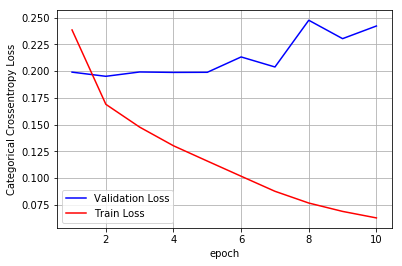

In [26]:
epochs=10
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

#### There is differnece b/w training and test loss just because we have only used 100k datapoints and only taken 5000 top words this result can improve if we take more data and more top words but then it will take more time

## RNN Model with 2 LSTM and 2 Dropout

In [27]:
# create the model
from keras.layers import Dense, Dropout
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000+1, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.35))
model.add(LSTM(100))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160032    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 600, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,733
Trainable params: 293,733
Non-trainable params: 0
_________________________________________________________________
None

In [28]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 70000 samples, validate on 30000 samples
Epoch 1/10


12992/70000 [====>.........................] - ETA: 55:41 - loss: 0.6934 - acc: 0.43 - ETA: 43:59 - loss: 0.6886 - acc: 0.68 - ETA: 39:05 - loss: 0.6838 - acc: 0.76 - ETA: 36:24 - loss: 0.6785 - acc: 0.78 - ETA: 35:29 - loss: 0.6701 - acc: 0.81 - ETA: 34:30 - loss: 0.6617 - acc: 0.82 - ETA: 33:34 - loss: 0.6537 - acc: 0.82 - ETA: 33:15 - loss: 0.6404 - acc: 0.83 - ETA: 32:51 - loss: 0.6202 - acc: 0.83 - ETA: 32:25 - loss: 0.6033 - acc: 0.83 - ETA: 32:16 - loss: 0.5925 - acc: 0.83 - ETA: 32:05 - loss: 0.5829 - acc: 0.83 - ETA: 31:46 - loss: 0.5672 - acc: 0.84 - ETA: 31:29 - loss: 0.5512 - acc: 0.84 - ETA: 31:31 - loss: 0.5363 - acc: 0.84 - ETA: 31:17 - loss: 0.5312 - acc: 0.84 - ETA: 31:03 - loss: 0.5186 - acc: 0.85 - ETA: 31:02 - loss: 0.5114 - acc: 0.85 - ETA: 30:55 - loss: 0.4976 - acc: 0.85 - ETA: 30:45 - loss: 0.4927 - acc: 0.85 - ETA: 30:43 - loss: 0.4883 - acc: 0.85 - ETA: 30:38 - loss: 0.4821 - acc: 0.85 - ETA: 30:30 - loss: 0.4818 - acc: 0.85 - ETA: 30:29 - loss: 0.4781 - acc: 

52160/70000 [=====================>........] - ETA: 13:17 - loss: 0.2558 - acc: 0.90 - ETA: 13:16 - loss: 0.2558 - acc: 0.90 - ETA: 13:14 - loss: 0.2556 - acc: 0.90 - ETA: 13:12 - loss: 0.2554 - acc: 0.90 - ETA: 13:11 - loss: 0.2553 - acc: 0.90 - ETA: 13:09 - loss: 0.2552 - acc: 0.90 - ETA: 13:07 - loss: 0.2550 - acc: 0.90 - ETA: 13:06 - loss: 0.2548 - acc: 0.90 - ETA: 13:04 - loss: 0.2548 - acc: 0.90 - ETA: 13:02 - loss: 0.2548 - acc: 0.90 - ETA: 13:01 - loss: 0.2549 - acc: 0.90 - ETA: 12:59 - loss: 0.2549 - acc: 0.90 - ETA: 12:57 - loss: 0.2552 - acc: 0.90 - ETA: 12:56 - loss: 0.2551 - acc: 0.90 - ETA: 12:54 - loss: 0.2550 - acc: 0.90 - ETA: 12:53 - loss: 0.2549 - acc: 0.90 - ETA: 12:51 - loss: 0.2548 - acc: 0.90 - ETA: 12:49 - loss: 0.2549 - acc: 0.90 - ETA: 12:48 - loss: 0.2549 - acc: 0.90 - ETA: 12:46 - loss: 0.2548 - acc: 0.90 - ETA: 12:44 - loss: 0.2547 - acc: 0.90 - ETA: 12:43 - loss: 0.2545 - acc: 0.90 - ETA: 12:41 - loss: 0.2552 - acc: 0.90 - ETA: 12:39 - loss: 0.2553 - acc: 

65216/70000 [==========================>...] - ETA: 7:39 - loss: 0.2459 - acc: 0.908 - ETA: 7:38 - loss: 0.2460 - acc: 0.908 - ETA: 7:36 - loss: 0.2459 - acc: 0.908 - ETA: 7:34 - loss: 0.2458 - acc: 0.908 - ETA: 7:33 - loss: 0.2457 - acc: 0.908 - ETA: 7:31 - loss: 0.2456 - acc: 0.909 - ETA: 7:29 - loss: 0.2454 - acc: 0.909 - ETA: 7:28 - loss: 0.2454 - acc: 0.909 - ETA: 7:26 - loss: 0.2453 - acc: 0.909 - ETA: 7:24 - loss: 0.2452 - acc: 0.909 - ETA: 7:23 - loss: 0.2453 - acc: 0.909 - ETA: 7:21 - loss: 0.2452 - acc: 0.909 - ETA: 7:19 - loss: 0.2453 - acc: 0.909 - ETA: 7:18 - loss: 0.2451 - acc: 0.909 - ETA: 7:16 - loss: 0.2450 - acc: 0.909 - ETA: 7:14 - loss: 0.2448 - acc: 0.909 - ETA: 7:13 - loss: 0.2446 - acc: 0.909 - ETA: 7:11 - loss: 0.2445 - acc: 0.909 - ETA: 7:09 - loss: 0.2442 - acc: 0.909 - ETA: 7:08 - loss: 0.2441 - acc: 0.909 - ETA: 7:06 - loss: 0.2440 - acc: 0.909 - ETA: 7:04 - loss: 0.2439 - acc: 0.909 - ETA: 7:03 - loss: 0.2439 - acc: 0.909 - ETA: 7:01 - loss: 0.2439 - acc: 0

70000/70000 [==============================] - ETA: 2:01 - loss: 0.2362 - acc: 0.912 - ETA: 2:00 - loss: 0.2361 - acc: 0.912 - ETA: 1:58 - loss: 0.2361 - acc: 0.912 - ETA: 1:57 - loss: 0.2361 - acc: 0.912 - ETA: 1:55 - loss: 0.2360 - acc: 0.912 - ETA: 1:53 - loss: 0.2358 - acc: 0.912 - ETA: 1:52 - loss: 0.2359 - acc: 0.912 - ETA: 1:50 - loss: 0.2358 - acc: 0.912 - ETA: 1:48 - loss: 0.2357 - acc: 0.912 - ETA: 1:47 - loss: 0.2356 - acc: 0.912 - ETA: 1:45 - loss: 0.2357 - acc: 0.912 - ETA: 1:43 - loss: 0.2355 - acc: 0.912 - ETA: 1:42 - loss: 0.2355 - acc: 0.912 - ETA: 1:40 - loss: 0.2353 - acc: 0.912 - ETA: 1:38 - loss: 0.2353 - acc: 0.912 - ETA: 1:37 - loss: 0.2353 - acc: 0.912 - ETA: 1:35 - loss: 0.2353 - acc: 0.912 - ETA: 1:33 - loss: 0.2354 - acc: 0.912 - ETA: 1:32 - loss: 0.2354 - acc: 0.912 - ETA: 1:30 - loss: 0.2353 - acc: 0.912 - ETA: 1:28 - loss: 0.2354 - acc: 0.912 - ETA: 1:27 - loss: 0.2354 - acc: 0.912 - ETA: 1:25 - loss: 0.2354 - acc: 0.912 - ETA: 1:23 - loss: 0.2355 - acc: 0

13056/70000 [====>.........................] - ETA: 32:43 - loss: 0.1469 - acc: 0.95 - ETA: 30:28 - loss: 0.1515 - acc: 0.93 - ETA: 29:59 - loss: 0.1471 - acc: 0.94 - ETA: 30:39 - loss: 0.1511 - acc: 0.94 - ETA: 30:19 - loss: 0.1437 - acc: 0.94 - ETA: 29:56 - loss: 0.1589 - acc: 0.94 - ETA: 30:16 - loss: 0.1678 - acc: 0.93 - ETA: 30:00 - loss: 0.1715 - acc: 0.93 - ETA: 29:53 - loss: 0.1733 - acc: 0.93 - ETA: 30:03 - loss: 0.1719 - acc: 0.93 - ETA: 30:23 - loss: 0.1699 - acc: 0.94 - ETA: 30:13 - loss: 0.1704 - acc: 0.93 - ETA: 30:02 - loss: 0.1612 - acc: 0.94 - ETA: 30:12 - loss: 0.1581 - acc: 0.94 - ETA: 30:03 - loss: 0.1569 - acc: 0.94 - ETA: 29:53 - loss: 0.1539 - acc: 0.94 - ETA: 30:07 - loss: 0.1588 - acc: 0.94 - ETA: 29:59 - loss: 0.1601 - acc: 0.94 - ETA: 29:52 - loss: 0.1583 - acc: 0.94 - ETA: 29:58 - loss: 0.1586 - acc: 0.94 - ETA: 29:52 - loss: 0.1668 - acc: 0.93 - ETA: 29:44 - loss: 0.1635 - acc: 0.93 - ETA: 29:49 - loss: 0.1681 - acc: 0.93 - ETA: 29:43 - loss: 0.1722 - acc: 

52224/70000 [=====================>........] - ETA: 13:13 - loss: 0.1683 - acc: 0.93 - ETA: 13:11 - loss: 0.1683 - acc: 0.93 - ETA: 13:09 - loss: 0.1683 - acc: 0.93 - ETA: 13:08 - loss: 0.1684 - acc: 0.93 - ETA: 13:06 - loss: 0.1683 - acc: 0.93 - ETA: 13:04 - loss: 0.1682 - acc: 0.93 - ETA: 13:03 - loss: 0.1684 - acc: 0.93 - ETA: 13:01 - loss: 0.1684 - acc: 0.93 - ETA: 12:59 - loss: 0.1684 - acc: 0.93 - ETA: 12:58 - loss: 0.1683 - acc: 0.93 - ETA: 12:56 - loss: 0.1683 - acc: 0.93 - ETA: 12:54 - loss: 0.1683 - acc: 0.93 - ETA: 12:53 - loss: 0.1683 - acc: 0.93 - ETA: 12:51 - loss: 0.1682 - acc: 0.93 - ETA: 12:49 - loss: 0.1683 - acc: 0.93 - ETA: 12:48 - loss: 0.1682 - acc: 0.93 - ETA: 12:46 - loss: 0.1684 - acc: 0.93 - ETA: 12:45 - loss: 0.1682 - acc: 0.93 - ETA: 12:43 - loss: 0.1683 - acc: 0.93 - ETA: 12:41 - loss: 0.1683 - acc: 0.93 - ETA: 12:40 - loss: 0.1681 - acc: 0.93 - ETA: 12:38 - loss: 0.1681 - acc: 0.93 - ETA: 12:36 - loss: 0.1681 - acc: 0.93 - ETA: 12:35 - loss: 0.1681 - acc: 

65280/70000 [==========================>...] - ETA: 7:36 - loss: 0.1671 - acc: 0.937 - ETA: 7:34 - loss: 0.1671 - acc: 0.937 - ETA: 7:33 - loss: 0.1672 - acc: 0.937 - ETA: 7:31 - loss: 0.1672 - acc: 0.937 - ETA: 7:29 - loss: 0.1674 - acc: 0.936 - ETA: 7:28 - loss: 0.1675 - acc: 0.936 - ETA: 7:26 - loss: 0.1674 - acc: 0.936 - ETA: 7:24 - loss: 0.1676 - acc: 0.936 - ETA: 7:23 - loss: 0.1675 - acc: 0.936 - ETA: 7:21 - loss: 0.1675 - acc: 0.936 - ETA: 7:19 - loss: 0.1675 - acc: 0.936 - ETA: 7:18 - loss: 0.1674 - acc: 0.936 - ETA: 7:16 - loss: 0.1675 - acc: 0.936 - ETA: 7:15 - loss: 0.1675 - acc: 0.936 - ETA: 7:13 - loss: 0.1675 - acc: 0.936 - ETA: 7:11 - loss: 0.1676 - acc: 0.936 - ETA: 7:10 - loss: 0.1677 - acc: 0.936 - ETA: 7:08 - loss: 0.1677 - acc: 0.936 - ETA: 7:06 - loss: 0.1677 - acc: 0.936 - ETA: 7:05 - loss: 0.1678 - acc: 0.936 - ETA: 7:03 - loss: 0.1679 - acc: 0.936 - ETA: 7:01 - loss: 0.1678 - acc: 0.936 - ETA: 7:00 - loss: 0.1678 - acc: 0.936 - ETA: 6:58 - loss: 0.1678 - acc: 0

70000/70000 [==============================] - ETA: 2:00 - loss: 0.1679 - acc: 0.936 - ETA: 1:58 - loss: 0.1680 - acc: 0.936 - ETA: 1:56 - loss: 0.1679 - acc: 0.936 - ETA: 1:55 - loss: 0.1679 - acc: 0.936 - ETA: 1:53 - loss: 0.1679 - acc: 0.936 - ETA: 1:51 - loss: 0.1679 - acc: 0.936 - ETA: 1:50 - loss: 0.1679 - acc: 0.936 - ETA: 1:48 - loss: 0.1680 - acc: 0.936 - ETA: 1:46 - loss: 0.1679 - acc: 0.936 - ETA: 1:45 - loss: 0.1679 - acc: 0.936 - ETA: 1:43 - loss: 0.1679 - acc: 0.936 - ETA: 1:41 - loss: 0.1678 - acc: 0.936 - ETA: 1:40 - loss: 0.1678 - acc: 0.936 - ETA: 1:38 - loss: 0.1677 - acc: 0.936 - ETA: 1:36 - loss: 0.1677 - acc: 0.936 - ETA: 1:35 - loss: 0.1677 - acc: 0.936 - ETA: 1:33 - loss: 0.1676 - acc: 0.936 - ETA: 1:31 - loss: 0.1676 - acc: 0.936 - ETA: 1:30 - loss: 0.1676 - acc: 0.936 - ETA: 1:28 - loss: 0.1676 - acc: 0.936 - ETA: 1:27 - loss: 0.1676 - acc: 0.936 - ETA: 1:25 - loss: 0.1677 - acc: 0.936 - ETA: 1:23 - loss: 0.1676 - acc: 0.936 - ETA: 1:22 - loss: 0.1675 - acc: 0

13056/70000 [====>.........................] - ETA: 28:39 - loss: 0.1253 - acc: 0.93 - ETA: 29:47 - loss: 0.1038 - acc: 0.96 - ETA: 30:24 - loss: 0.0877 - acc: 0.97 - ETA: 29:53 - loss: 0.0876 - acc: 0.97 - ETA: 29:59 - loss: 0.0884 - acc: 0.96 - ETA: 29:41 - loss: 0.0824 - acc: 0.97 - ETA: 29:54 - loss: 0.0879 - acc: 0.97 - ETA: 29:57 - loss: 0.1007 - acc: 0.96 - ETA: 29:45 - loss: 0.1004 - acc: 0.96 - ETA: 29:47 - loss: 0.1113 - acc: 0.96 - ETA: 29:38 - loss: 0.1140 - acc: 0.96 - ETA: 29:39 - loss: 0.1192 - acc: 0.96 - ETA: 29:44 - loss: 0.1163 - acc: 0.96 - ETA: 29:34 - loss: 0.1143 - acc: 0.96 - ETA: 29:36 - loss: 0.1159 - acc: 0.96 - ETA: 29:38 - loss: 0.1232 - acc: 0.96 - ETA: 29:32 - loss: 0.1239 - acc: 0.95 - ETA: 29:32 - loss: 0.1239 - acc: 0.95 - ETA: 29:37 - loss: 0.1261 - acc: 0.95 - ETA: 29:30 - loss: 0.1253 - acc: 0.95 - ETA: 29:28 - loss: 0.1226 - acc: 0.95 - ETA: 29:23 - loss: 0.1215 - acc: 0.95 - ETA: 29:26 - loss: 0.1206 - acc: 0.95 - ETA: 29:25 - loss: 0.1246 - acc: 

52224/70000 [=====================>........] - ETA: 13:15 - loss: 0.1468 - acc: 0.94 - ETA: 13:13 - loss: 0.1469 - acc: 0.94 - ETA: 13:11 - loss: 0.1468 - acc: 0.94 - ETA: 13:10 - loss: 0.1468 - acc: 0.94 - ETA: 13:08 - loss: 0.1469 - acc: 0.94 - ETA: 13:06 - loss: 0.1471 - acc: 0.94 - ETA: 13:05 - loss: 0.1471 - acc: 0.94 - ETA: 13:03 - loss: 0.1472 - acc: 0.94 - ETA: 13:01 - loss: 0.1472 - acc: 0.94 - ETA: 13:00 - loss: 0.1472 - acc: 0.94 - ETA: 12:58 - loss: 0.1471 - acc: 0.94 - ETA: 12:56 - loss: 0.1471 - acc: 0.94 - ETA: 12:55 - loss: 0.1472 - acc: 0.94 - ETA: 12:53 - loss: 0.1474 - acc: 0.94 - ETA: 12:52 - loss: 0.1473 - acc: 0.94 - ETA: 12:50 - loss: 0.1473 - acc: 0.94 - ETA: 12:48 - loss: 0.1473 - acc: 0.94 - ETA: 12:47 - loss: 0.1473 - acc: 0.94 - ETA: 12:45 - loss: 0.1473 - acc: 0.94 - ETA: 12:43 - loss: 0.1473 - acc: 0.94 - ETA: 12:42 - loss: 0.1474 - acc: 0.94 - ETA: 12:40 - loss: 0.1473 - acc: 0.94 - ETA: 12:38 - loss: 0.1473 - acc: 0.94 - ETA: 12:37 - loss: 0.1473 - acc: 

65280/70000 [==========================>...] - ETA: 7:37 - loss: 0.1466 - acc: 0.946 - ETA: 7:35 - loss: 0.1466 - acc: 0.946 - ETA: 7:34 - loss: 0.1467 - acc: 0.946 - ETA: 7:32 - loss: 0.1466 - acc: 0.946 - ETA: 7:30 - loss: 0.1467 - acc: 0.946 - ETA: 7:29 - loss: 0.1467 - acc: 0.946 - ETA: 7:27 - loss: 0.1467 - acc: 0.946 - ETA: 7:25 - loss: 0.1467 - acc: 0.946 - ETA: 7:24 - loss: 0.1467 - acc: 0.946 - ETA: 7:22 - loss: 0.1467 - acc: 0.946 - ETA: 7:20 - loss: 0.1466 - acc: 0.946 - ETA: 7:19 - loss: 0.1467 - acc: 0.946 - ETA: 7:17 - loss: 0.1467 - acc: 0.946 - ETA: 7:15 - loss: 0.1467 - acc: 0.946 - ETA: 7:14 - loss: 0.1466 - acc: 0.946 - ETA: 7:12 - loss: 0.1465 - acc: 0.946 - ETA: 7:11 - loss: 0.1465 - acc: 0.946 - ETA: 7:09 - loss: 0.1464 - acc: 0.946 - ETA: 7:07 - loss: 0.1466 - acc: 0.946 - ETA: 7:06 - loss: 0.1466 - acc: 0.946 - ETA: 7:04 - loss: 0.1466 - acc: 0.946 - ETA: 7:02 - loss: 0.1465 - acc: 0.946 - ETA: 7:01 - loss: 0.1466 - acc: 0.946 - ETA: 6:59 - loss: 0.1465 - acc: 0

70000/70000 [==============================] - ETA: 2:00 - loss: 0.1478 - acc: 0.945 - ETA: 1:58 - loss: 0.1478 - acc: 0.945 - ETA: 1:56 - loss: 0.1478 - acc: 0.945 - ETA: 1:55 - loss: 0.1478 - acc: 0.945 - ETA: 1:53 - loss: 0.1478 - acc: 0.945 - ETA: 1:51 - loss: 0.1479 - acc: 0.945 - ETA: 1:50 - loss: 0.1481 - acc: 0.945 - ETA: 1:48 - loss: 0.1481 - acc: 0.945 - ETA: 1:47 - loss: 0.1481 - acc: 0.945 - ETA: 1:45 - loss: 0.1481 - acc: 0.945 - ETA: 1:43 - loss: 0.1482 - acc: 0.945 - ETA: 1:42 - loss: 0.1481 - acc: 0.945 - ETA: 1:40 - loss: 0.1481 - acc: 0.945 - ETA: 1:38 - loss: 0.1481 - acc: 0.945 - ETA: 1:37 - loss: 0.1481 - acc: 0.945 - ETA: 1:35 - loss: 0.1480 - acc: 0.945 - ETA: 1:33 - loss: 0.1480 - acc: 0.945 - ETA: 1:32 - loss: 0.1480 - acc: 0.945 - ETA: 1:30 - loss: 0.1480 - acc: 0.945 - ETA: 1:28 - loss: 0.1479 - acc: 0.945 - ETA: 1:27 - loss: 0.1479 - acc: 0.945 - ETA: 1:25 - loss: 0.1478 - acc: 0.945 - ETA: 1:23 - loss: 0.1478 - acc: 0.945 - ETA: 1:22 - loss: 0.1479 - acc: 0

13056/70000 [====>.........................] - ETA: 28:35 - loss: 0.0573 - acc: 1.00 - ETA: 29:07 - loss: 0.0677 - acc: 0.98 - ETA: 30:03 - loss: 0.1557 - acc: 0.95 - ETA: 29:41 - loss: 0.1593 - acc: 0.94 - ETA: 29:42 - loss: 0.1944 - acc: 0.93 - ETA: 29:59 - loss: 0.1677 - acc: 0.94 - ETA: 29:47 - loss: 0.1577 - acc: 0.94 - ETA: 29:42 - loss: 0.1584 - acc: 0.94 - ETA: 30:00 - loss: 0.1512 - acc: 0.94 - ETA: 29:59 - loss: 0.1521 - acc: 0.94 - ETA: 29:47 - loss: 0.1465 - acc: 0.94 - ETA: 30:02 - loss: 0.1494 - acc: 0.94 - ETA: 29:55 - loss: 0.1458 - acc: 0.94 - ETA: 29:46 - loss: 0.1446 - acc: 0.94 - ETA: 29:45 - loss: 0.1468 - acc: 0.94 - ETA: 29:48 - loss: 0.1414 - acc: 0.94 - ETA: 29:39 - loss: 0.1430 - acc: 0.94 - ETA: 29:39 - loss: 0.1466 - acc: 0.94 - ETA: 29:41 - loss: 0.1443 - acc: 0.94 - ETA: 29:36 - loss: 0.1419 - acc: 0.94 - ETA: 29:35 - loss: 0.1398 - acc: 0.94 - ETA: 29:36 - loss: 0.1355 - acc: 0.94 - ETA: 29:30 - loss: 0.1361 - acc: 0.94 - ETA: 29:28 - loss: 0.1332 - acc: 

52224/70000 [=====================>........] - ETA: 13:18 - loss: 0.1365 - acc: 0.95 - ETA: 13:16 - loss: 0.1365 - acc: 0.95 - ETA: 13:15 - loss: 0.1364 - acc: 0.95 - ETA: 13:13 - loss: 0.1365 - acc: 0.95 - ETA: 13:11 - loss: 0.1364 - acc: 0.95 - ETA: 13:10 - loss: 0.1365 - acc: 0.95 - ETA: 13:08 - loss: 0.1364 - acc: 0.95 - ETA: 13:06 - loss: 0.1364 - acc: 0.95 - ETA: 13:05 - loss: 0.1364 - acc: 0.95 - ETA: 13:03 - loss: 0.1364 - acc: 0.95 - ETA: 13:01 - loss: 0.1363 - acc: 0.95 - ETA: 13:00 - loss: 0.1364 - acc: 0.95 - ETA: 12:59 - loss: 0.1363 - acc: 0.95 - ETA: 12:57 - loss: 0.1362 - acc: 0.95 - ETA: 12:55 - loss: 0.1363 - acc: 0.95 - ETA: 12:54 - loss: 0.1364 - acc: 0.95 - ETA: 12:52 - loss: 0.1363 - acc: 0.95 - ETA: 12:51 - loss: 0.1363 - acc: 0.95 - ETA: 12:49 - loss: 0.1363 - acc: 0.95 - ETA: 12:47 - loss: 0.1362 - acc: 0.95 - ETA: 12:46 - loss: 0.1361 - acc: 0.95 - ETA: 12:44 - loss: 0.1361 - acc: 0.95 - ETA: 12:42 - loss: 0.1361 - acc: 0.95 - ETA: 12:41 - loss: 0.1362 - acc: 

65280/70000 [==========================>...] - ETA: 7:44 - loss: 0.1357 - acc: 0.950 - ETA: 7:43 - loss: 0.1358 - acc: 0.950 - ETA: 7:41 - loss: 0.1358 - acc: 0.950 - ETA: 7:39 - loss: 0.1358 - acc: 0.950 - ETA: 7:38 - loss: 0.1357 - acc: 0.950 - ETA: 7:36 - loss: 0.1357 - acc: 0.950 - ETA: 7:34 - loss: 0.1358 - acc: 0.950 - ETA: 7:33 - loss: 0.1358 - acc: 0.950 - ETA: 7:31 - loss: 0.1358 - acc: 0.950 - ETA: 7:29 - loss: 0.1358 - acc: 0.950 - ETA: 7:28 - loss: 0.1357 - acc: 0.950 - ETA: 7:26 - loss: 0.1356 - acc: 0.950 - ETA: 7:24 - loss: 0.1357 - acc: 0.950 - ETA: 7:23 - loss: 0.1356 - acc: 0.950 - ETA: 7:21 - loss: 0.1356 - acc: 0.950 - ETA: 7:19 - loss: 0.1356 - acc: 0.950 - ETA: 7:18 - loss: 0.1356 - acc: 0.950 - ETA: 7:16 - loss: 0.1356 - acc: 0.950 - ETA: 7:14 - loss: 0.1356 - acc: 0.950 - ETA: 7:13 - loss: 0.1355 - acc: 0.950 - ETA: 7:11 - loss: 0.1354 - acc: 0.950 - ETA: 7:09 - loss: 0.1353 - acc: 0.950 - ETA: 7:08 - loss: 0.1353 - acc: 0.950 - ETA: 7:06 - loss: 0.1353 - acc: 0

70000/70000 [==============================] - ETA: 2:02 - loss: 0.1343 - acc: 0.950 - ETA: 2:00 - loss: 0.1343 - acc: 0.950 - ETA: 1:58 - loss: 0.1344 - acc: 0.950 - ETA: 1:57 - loss: 0.1344 - acc: 0.950 - ETA: 1:55 - loss: 0.1343 - acc: 0.950 - ETA: 1:53 - loss: 0.1343 - acc: 0.950 - ETA: 1:52 - loss: 0.1343 - acc: 0.950 - ETA: 1:50 - loss: 0.1343 - acc: 0.950 - ETA: 1:48 - loss: 0.1343 - acc: 0.950 - ETA: 1:46 - loss: 0.1343 - acc: 0.950 - ETA: 1:45 - loss: 0.1342 - acc: 0.950 - ETA: 1:43 - loss: 0.1342 - acc: 0.950 - ETA: 1:41 - loss: 0.1342 - acc: 0.950 - ETA: 1:40 - loss: 0.1342 - acc: 0.950 - ETA: 1:38 - loss: 0.1343 - acc: 0.950 - ETA: 1:36 - loss: 0.1343 - acc: 0.950 - ETA: 1:35 - loss: 0.1342 - acc: 0.950 - ETA: 1:33 - loss: 0.1344 - acc: 0.950 - ETA: 1:31 - loss: 0.1344 - acc: 0.950 - ETA: 1:30 - loss: 0.1343 - acc: 0.950 - ETA: 1:28 - loss: 0.1344 - acc: 0.950 - ETA: 1:26 - loss: 0.1344 - acc: 0.950 - ETA: 1:25 - loss: 0.1344 - acc: 0.950 - ETA: 1:23 - loss: 0.1344 - acc: 0

13056/70000 [====>.........................] - ETA: 32:26 - loss: 0.0708 - acc: 0.98 - ETA: 30:34 - loss: 0.0815 - acc: 0.96 - ETA: 29:58 - loss: 0.0852 - acc: 0.96 - ETA: 30:49 - loss: 0.0906 - acc: 0.96 - ETA: 30:24 - loss: 0.1021 - acc: 0.95 - ETA: 30:03 - loss: 0.0961 - acc: 0.96 - ETA: 29:49 - loss: 0.0910 - acc: 0.96 - ETA: 30:05 - loss: 0.1086 - acc: 0.96 - ETA: 29:52 - loss: 0.1069 - acc: 0.96 - ETA: 29:43 - loss: 0.1045 - acc: 0.96 - ETA: 30:03 - loss: 0.1066 - acc: 0.96 - ETA: 29:53 - loss: 0.0994 - acc: 0.96 - ETA: 29:45 - loss: 0.1016 - acc: 0.96 - ETA: 29:54 - loss: 0.0999 - acc: 0.96 - ETA: 29:48 - loss: 0.1028 - acc: 0.96 - ETA: 29:44 - loss: 0.1022 - acc: 0.96 - ETA: 29:57 - loss: 0.1088 - acc: 0.96 - ETA: 29:49 - loss: 0.1161 - acc: 0.95 - ETA: 29:43 - loss: 0.1150 - acc: 0.95 - ETA: 29:51 - loss: 0.1134 - acc: 0.96 - ETA: 29:43 - loss: 0.1099 - acc: 0.96 - ETA: 29:37 - loss: 0.1070 - acc: 0.96 - ETA: 29:32 - loss: 0.1052 - acc: 0.96 - ETA: 29:35 - loss: 0.1042 - acc: 

52224/70000 [=====================>........] - ETA: 13:18 - loss: 0.1113 - acc: 0.96 - ETA: 13:16 - loss: 0.1114 - acc: 0.96 - ETA: 13:15 - loss: 0.1113 - acc: 0.96 - ETA: 13:13 - loss: 0.1115 - acc: 0.96 - ETA: 13:11 - loss: 0.1115 - acc: 0.96 - ETA: 13:10 - loss: 0.1116 - acc: 0.96 - ETA: 13:08 - loss: 0.1116 - acc: 0.96 - ETA: 13:06 - loss: 0.1115 - acc: 0.96 - ETA: 13:05 - loss: 0.1115 - acc: 0.96 - ETA: 13:03 - loss: 0.1115 - acc: 0.96 - ETA: 13:01 - loss: 0.1115 - acc: 0.96 - ETA: 13:00 - loss: 0.1115 - acc: 0.96 - ETA: 12:58 - loss: 0.1116 - acc: 0.96 - ETA: 12:56 - loss: 0.1116 - acc: 0.96 - ETA: 12:55 - loss: 0.1115 - acc: 0.96 - ETA: 12:53 - loss: 0.1116 - acc: 0.96 - ETA: 12:51 - loss: 0.1117 - acc: 0.96 - ETA: 12:50 - loss: 0.1117 - acc: 0.96 - ETA: 12:48 - loss: 0.1119 - acc: 0.96 - ETA: 12:46 - loss: 0.1117 - acc: 0.96 - ETA: 12:45 - loss: 0.1118 - acc: 0.96 - ETA: 12:43 - loss: 0.1117 - acc: 0.96 - ETA: 12:41 - loss: 0.1117 - acc: 0.96 - ETA: 12:40 - loss: 0.1116 - acc: 

65280/70000 [==========================>...] - ETA: 7:40 - loss: 0.1137 - acc: 0.960 - ETA: 7:38 - loss: 0.1137 - acc: 0.960 - ETA: 7:36 - loss: 0.1138 - acc: 0.960 - ETA: 7:35 - loss: 0.1139 - acc: 0.959 - ETA: 7:33 - loss: 0.1142 - acc: 0.959 - ETA: 7:31 - loss: 0.1142 - acc: 0.959 - ETA: 7:30 - loss: 0.1142 - acc: 0.959 - ETA: 7:28 - loss: 0.1142 - acc: 0.959 - ETA: 7:26 - loss: 0.1143 - acc: 0.959 - ETA: 7:25 - loss: 0.1143 - acc: 0.959 - ETA: 7:23 - loss: 0.1143 - acc: 0.959 - ETA: 7:21 - loss: 0.1142 - acc: 0.959 - ETA: 7:20 - loss: 0.1141 - acc: 0.959 - ETA: 7:18 - loss: 0.1141 - acc: 0.959 - ETA: 7:16 - loss: 0.1141 - acc: 0.959 - ETA: 7:15 - loss: 0.1141 - acc: 0.959 - ETA: 7:13 - loss: 0.1141 - acc: 0.959 - ETA: 7:11 - loss: 0.1140 - acc: 0.959 - ETA: 7:10 - loss: 0.1140 - acc: 0.959 - ETA: 7:08 - loss: 0.1139 - acc: 0.959 - ETA: 7:06 - loss: 0.1139 - acc: 0.959 - ETA: 7:05 - loss: 0.1139 - acc: 0.959 - ETA: 7:03 - loss: 0.1139 - acc: 0.959 - ETA: 7:01 - loss: 0.1140 - acc: 0

70000/70000 [==============================] - ETA: 2:00 - loss: 0.1155 - acc: 0.959 - ETA: 1:59 - loss: 0.1154 - acc: 0.959 - ETA: 1:57 - loss: 0.1153 - acc: 0.959 - ETA: 1:55 - loss: 0.1153 - acc: 0.959 - ETA: 1:54 - loss: 0.1153 - acc: 0.959 - ETA: 1:52 - loss: 0.1152 - acc: 0.959 - ETA: 1:50 - loss: 0.1152 - acc: 0.959 - ETA: 1:49 - loss: 0.1153 - acc: 0.959 - ETA: 1:47 - loss: 0.1152 - acc: 0.959 - ETA: 1:45 - loss: 0.1151 - acc: 0.959 - ETA: 1:44 - loss: 0.1151 - acc: 0.959 - ETA: 1:42 - loss: 0.1150 - acc: 0.959 - ETA: 1:40 - loss: 0.1150 - acc: 0.959 - ETA: 1:39 - loss: 0.1150 - acc: 0.959 - ETA: 1:37 - loss: 0.1150 - acc: 0.959 - ETA: 1:35 - loss: 0.1151 - acc: 0.959 - ETA: 1:34 - loss: 0.1151 - acc: 0.959 - ETA: 1:32 - loss: 0.1153 - acc: 0.959 - ETA: 1:30 - loss: 0.1152 - acc: 0.959 - ETA: 1:29 - loss: 0.1152 - acc: 0.959 - ETA: 1:27 - loss: 0.1152 - acc: 0.959 - ETA: 1:25 - loss: 0.1152 - acc: 0.959 - ETA: 1:24 - loss: 0.1152 - acc: 0.959 - ETA: 1:22 - loss: 0.1153 - acc: 0

13056/70000 [====>.........................] - ETA: 28:00 - loss: 0.0565 - acc: 0.96 - ETA: 30:01 - loss: 0.0589 - acc: 0.97 - ETA: 30:22 - loss: 0.0488 - acc: 0.98 - ETA: 30:00 - loss: 0.0764 - acc: 0.97 - ETA: 30:18 - loss: 0.0709 - acc: 0.97 - ETA: 30:21 - loss: 0.0667 - acc: 0.97 - ETA: 30:01 - loss: 0.0682 - acc: 0.97 - ETA: 30:07 - loss: 0.0648 - acc: 0.97 - ETA: 30:05 - loss: 0.0688 - acc: 0.97 - ETA: 29:59 - loss: 0.0651 - acc: 0.97 - ETA: 29:55 - loss: 0.0655 - acc: 0.97 - ETA: 30:07 - loss: 0.0794 - acc: 0.97 - ETA: 29:57 - loss: 0.0810 - acc: 0.97 - ETA: 29:56 - loss: 0.0777 - acc: 0.97 - ETA: 30:05 - loss: 0.0779 - acc: 0.97 - ETA: 30:03 - loss: 0.0752 - acc: 0.97 - ETA: 29:56 - loss: 0.0732 - acc: 0.97 - ETA: 29:58 - loss: 0.0748 - acc: 0.97 - ETA: 29:57 - loss: 0.0729 - acc: 0.97 - ETA: 29:48 - loss: 0.0731 - acc: 0.97 - ETA: 29:50 - loss: 0.0719 - acc: 0.97 - ETA: 29:52 - loss: 0.0714 - acc: 0.97 - ETA: 29:45 - loss: 0.0688 - acc: 0.97 - ETA: 29:46 - loss: 0.0672 - acc: 

52224/70000 [=====================>........] - ETA: 13:26 - loss: 0.0939 - acc: 0.96 - ETA: 13:24 - loss: 0.0939 - acc: 0.96 - ETA: 13:22 - loss: 0.0940 - acc: 0.96 - ETA: 13:20 - loss: 0.0940 - acc: 0.96 - ETA: 13:19 - loss: 0.0941 - acc: 0.96 - ETA: 13:17 - loss: 0.0940 - acc: 0.96 - ETA: 13:16 - loss: 0.0939 - acc: 0.96 - ETA: 13:14 - loss: 0.0940 - acc: 0.96 - ETA: 13:12 - loss: 0.0941 - acc: 0.96 - ETA: 13:11 - loss: 0.0942 - acc: 0.96 - ETA: 13:09 - loss: 0.0942 - acc: 0.96 - ETA: 13:07 - loss: 0.0942 - acc: 0.96 - ETA: 13:06 - loss: 0.0942 - acc: 0.96 - ETA: 13:04 - loss: 0.0943 - acc: 0.96 - ETA: 13:02 - loss: 0.0942 - acc: 0.96 - ETA: 13:01 - loss: 0.0942 - acc: 0.96 - ETA: 12:59 - loss: 0.0942 - acc: 0.96 - ETA: 12:58 - loss: 0.0942 - acc: 0.96 - ETA: 12:56 - loss: 0.0942 - acc: 0.96 - ETA: 12:55 - loss: 0.0941 - acc: 0.96 - ETA: 12:53 - loss: 0.0942 - acc: 0.96 - ETA: 12:51 - loss: 0.0941 - acc: 0.96 - ETA: 12:50 - loss: 0.0941 - acc: 0.96 - ETA: 12:48 - loss: 0.0940 - acc: 

65280/70000 [==========================>...] - ETA: 7:43 - loss: 0.0955 - acc: 0.966 - ETA: 7:42 - loss: 0.0955 - acc: 0.966 - ETA: 7:40 - loss: 0.0955 - acc: 0.966 - ETA: 7:38 - loss: 0.0955 - acc: 0.966 - ETA: 7:37 - loss: 0.0955 - acc: 0.966 - ETA: 7:35 - loss: 0.0955 - acc: 0.966 - ETA: 7:33 - loss: 0.0955 - acc: 0.966 - ETA: 7:32 - loss: 0.0954 - acc: 0.966 - ETA: 7:30 - loss: 0.0954 - acc: 0.966 - ETA: 7:29 - loss: 0.0953 - acc: 0.966 - ETA: 7:27 - loss: 0.0953 - acc: 0.966 - ETA: 7:25 - loss: 0.0953 - acc: 0.966 - ETA: 7:24 - loss: 0.0952 - acc: 0.966 - ETA: 7:22 - loss: 0.0953 - acc: 0.966 - ETA: 7:20 - loss: 0.0952 - acc: 0.966 - ETA: 7:19 - loss: 0.0953 - acc: 0.966 - ETA: 7:17 - loss: 0.0954 - acc: 0.966 - ETA: 7:15 - loss: 0.0954 - acc: 0.966 - ETA: 7:13 - loss: 0.0954 - acc: 0.966 - ETA: 7:12 - loss: 0.0954 - acc: 0.966 - ETA: 7:10 - loss: 0.0953 - acc: 0.966 - ETA: 7:08 - loss: 0.0953 - acc: 0.966 - ETA: 7:07 - loss: 0.0954 - acc: 0.966 - ETA: 7:05 - loss: 0.0953 - acc: 0

70000/70000 [==============================] - ETA: 2:01 - loss: 0.0958 - acc: 0.966 - ETA: 2:00 - loss: 0.0958 - acc: 0.966 - ETA: 1:58 - loss: 0.0959 - acc: 0.966 - ETA: 1:56 - loss: 0.0959 - acc: 0.966 - ETA: 1:55 - loss: 0.0960 - acc: 0.966 - ETA: 1:53 - loss: 0.0959 - acc: 0.966 - ETA: 1:51 - loss: 0.0959 - acc: 0.966 - ETA: 1:50 - loss: 0.0958 - acc: 0.966 - ETA: 1:48 - loss: 0.0958 - acc: 0.966 - ETA: 1:46 - loss: 0.0958 - acc: 0.966 - ETA: 1:45 - loss: 0.0959 - acc: 0.966 - ETA: 1:43 - loss: 0.0958 - acc: 0.966 - ETA: 1:41 - loss: 0.0959 - acc: 0.966 - ETA: 1:40 - loss: 0.0960 - acc: 0.966 - ETA: 1:38 - loss: 0.0961 - acc: 0.966 - ETA: 1:36 - loss: 0.0961 - acc: 0.966 - ETA: 1:35 - loss: 0.0960 - acc: 0.966 - ETA: 1:33 - loss: 0.0960 - acc: 0.966 - ETA: 1:31 - loss: 0.0960 - acc: 0.966 - ETA: 1:30 - loss: 0.0961 - acc: 0.966 - ETA: 1:28 - loss: 0.0961 - acc: 0.966 - ETA: 1:26 - loss: 0.0961 - acc: 0.966 - ETA: 1:25 - loss: 0.0960 - acc: 0.966 - ETA: 1:23 - loss: 0.0961 - acc: 0

13056/70000 [====>.........................] - ETA: 28:39 - loss: 0.0296 - acc: 1.00 - ETA: 30:05 - loss: 0.0544 - acc: 0.98 - ETA: 30:32 - loss: 0.0440 - acc: 0.98 - ETA: 30:19 - loss: 0.0472 - acc: 0.98 - ETA: 30:36 - loss: 0.0467 - acc: 0.98 - ETA: 30:13 - loss: 0.0519 - acc: 0.98 - ETA: 30:31 - loss: 0.0570 - acc: 0.97 - ETA: 30:35 - loss: 0.0575 - acc: 0.97 - ETA: 30:17 - loss: 0.0631 - acc: 0.97 - ETA: 30:14 - loss: 0.0684 - acc: 0.97 - ETA: 30:21 - loss: 0.0681 - acc: 0.97 - ETA: 30:07 - loss: 0.0722 - acc: 0.97 - ETA: 30:06 - loss: 0.0682 - acc: 0.97 - ETA: 29:55 - loss: 0.0706 - acc: 0.97 - ETA: 29:58 - loss: 0.0685 - acc: 0.97 - ETA: 29:58 - loss: 0.0705 - acc: 0.97 - ETA: 29:51 - loss: 0.0808 - acc: 0.96 - ETA: 29:54 - loss: 0.0819 - acc: 0.96 - ETA: 29:54 - loss: 0.0814 - acc: 0.96 - ETA: 29:47 - loss: 0.0877 - acc: 0.96 - ETA: 29:50 - loss: 0.0845 - acc: 0.96 - ETA: 29:46 - loss: 0.0825 - acc: 0.96 - ETA: 29:39 - loss: 0.0800 - acc: 0.97 - ETA: 29:41 - loss: 0.0784 - acc: 

52224/70000 [=====================>........] - ETA: 14:18 - loss: 0.0806 - acc: 0.97 - ETA: 14:16 - loss: 0.0807 - acc: 0.97 - ETA: 14:14 - loss: 0.0807 - acc: 0.97 - ETA: 14:12 - loss: 0.0806 - acc: 0.97 - ETA: 14:10 - loss: 0.0806 - acc: 0.97 - ETA: 14:09 - loss: 0.0805 - acc: 0.97 - ETA: 14:07 - loss: 0.0806 - acc: 0.97 - ETA: 14:05 - loss: 0.0806 - acc: 0.97 - ETA: 14:04 - loss: 0.0808 - acc: 0.97 - ETA: 14:02 - loss: 0.0808 - acc: 0.97 - ETA: 14:00 - loss: 0.0808 - acc: 0.97 - ETA: 13:58 - loss: 0.0808 - acc: 0.97 - ETA: 13:57 - loss: 0.0809 - acc: 0.97 - ETA: 13:55 - loss: 0.0810 - acc: 0.97 - ETA: 13:53 - loss: 0.0811 - acc: 0.97 - ETA: 13:51 - loss: 0.0810 - acc: 0.97 - ETA: 13:49 - loss: 0.0811 - acc: 0.97 - ETA: 13:48 - loss: 0.0811 - acc: 0.97 - ETA: 13:46 - loss: 0.0813 - acc: 0.97 - ETA: 13:44 - loss: 0.0814 - acc: 0.97 - ETA: 13:42 - loss: 0.0815 - acc: 0.97 - ETA: 13:41 - loss: 0.0815 - acc: 0.97 - ETA: 13:39 - loss: 0.0815 - acc: 0.97 - ETA: 13:37 - loss: 0.0815 - acc: 

65280/70000 [==========================>...] - ETA: 8:16 - loss: 0.0825 - acc: 0.971 - ETA: 8:15 - loss: 0.0824 - acc: 0.971 - ETA: 8:13 - loss: 0.0824 - acc: 0.971 - ETA: 8:11 - loss: 0.0824 - acc: 0.971 - ETA: 8:09 - loss: 0.0824 - acc: 0.971 - ETA: 8:08 - loss: 0.0824 - acc: 0.971 - ETA: 8:06 - loss: 0.0823 - acc: 0.971 - ETA: 8:04 - loss: 0.0822 - acc: 0.971 - ETA: 8:02 - loss: 0.0823 - acc: 0.971 - ETA: 8:01 - loss: 0.0823 - acc: 0.971 - ETA: 7:59 - loss: 0.0822 - acc: 0.971 - ETA: 7:57 - loss: 0.0823 - acc: 0.971 - ETA: 7:55 - loss: 0.0823 - acc: 0.971 - ETA: 7:54 - loss: 0.0824 - acc: 0.971 - ETA: 7:52 - loss: 0.0823 - acc: 0.971 - ETA: 7:50 - loss: 0.0823 - acc: 0.971 - ETA: 7:48 - loss: 0.0824 - acc: 0.971 - ETA: 7:46 - loss: 0.0824 - acc: 0.971 - ETA: 7:45 - loss: 0.0824 - acc: 0.971 - ETA: 7:43 - loss: 0.0824 - acc: 0.971 - ETA: 7:41 - loss: 0.0824 - acc: 0.971 - ETA: 7:39 - loss: 0.0825 - acc: 0.971 - ETA: 7:38 - loss: 0.0824 - acc: 0.971 - ETA: 7:36 - loss: 0.0824 - acc: 0

70000/70000 [==============================] - ETA: 2:14 - loss: 0.0850 - acc: 0.970 - ETA: 2:12 - loss: 0.0850 - acc: 0.970 - ETA: 2:10 - loss: 0.0851 - acc: 0.970 - ETA: 2:08 - loss: 0.0852 - acc: 0.970 - ETA: 2:06 - loss: 0.0852 - acc: 0.970 - ETA: 2:05 - loss: 0.0852 - acc: 0.970 - ETA: 2:03 - loss: 0.0852 - acc: 0.970 - ETA: 2:01 - loss: 0.0854 - acc: 0.970 - ETA: 1:59 - loss: 0.0854 - acc: 0.970 - ETA: 1:57 - loss: 0.0853 - acc: 0.970 - ETA: 1:55 - loss: 0.0854 - acc: 0.970 - ETA: 1:54 - loss: 0.0854 - acc: 0.970 - ETA: 1:52 - loss: 0.0854 - acc: 0.970 - ETA: 1:50 - loss: 0.0854 - acc: 0.970 - ETA: 1:48 - loss: 0.0856 - acc: 0.970 - ETA: 1:46 - loss: 0.0856 - acc: 0.970 - ETA: 1:44 - loss: 0.0856 - acc: 0.970 - ETA: 1:43 - loss: 0.0857 - acc: 0.970 - ETA: 1:41 - loss: 0.0857 - acc: 0.970 - ETA: 1:39 - loss: 0.0857 - acc: 0.970 - ETA: 1:37 - loss: 0.0857 - acc: 0.970 - ETA: 1:35 - loss: 0.0857 - acc: 0.970 - ETA: 1:33 - loss: 0.0857 - acc: 0.970 - ETA: 1:32 - loss: 0.0857 - acc: 0

13056/70000 [====>.........................] - ETA: 41:34 - loss: 0.0768 - acc: 0.98 - ETA: 38:04 - loss: 0.0498 - acc: 0.99 - ETA: 36:46 - loss: 0.0432 - acc: 0.99 - ETA: 37:36 - loss: 0.0436 - acc: 0.99 - ETA: 36:59 - loss: 0.0499 - acc: 0.99 - ETA: 36:36 - loss: 0.0469 - acc: 0.99 - ETA: 37:05 - loss: 0.0568 - acc: 0.98 - ETA: 36:45 - loss: 0.0540 - acc: 0.98 - ETA: 37:07 - loss: 0.0552 - acc: 0.98 - ETA: 36:47 - loss: 0.0510 - acc: 0.98 - ETA: 36:32 - loss: 0.0618 - acc: 0.98 - ETA: 36:49 - loss: 0.0579 - acc: 0.98 - ETA: 36:37 - loss: 0.0606 - acc: 0.98 - ETA: 36:48 - loss: 0.0658 - acc: 0.97 - ETA: 36:39 - loss: 0.0676 - acc: 0.97 - ETA: 36:26 - loss: 0.0661 - acc: 0.97 - ETA: 36:36 - loss: 0.0657 - acc: 0.97 - ETA: 36:26 - loss: 0.0647 - acc: 0.97 - ETA: 36:17 - loss: 0.0657 - acc: 0.97 - ETA: 36:28 - loss: 0.0654 - acc: 0.97 - ETA: 36:21 - loss: 0.0688 - acc: 0.97 - ETA: 36:28 - loss: 0.0692 - acc: 0.97 - ETA: 36:20 - loss: 0.0688 - acc: 0.97 - ETA: 36:12 - loss: 0.0690 - acc: 

52224/70000 [=====================>........] - ETA: 16:21 - loss: 0.0695 - acc: 0.97 - ETA: 16:19 - loss: 0.0696 - acc: 0.97 - ETA: 16:17 - loss: 0.0695 - acc: 0.97 - ETA: 16:15 - loss: 0.0695 - acc: 0.97 - ETA: 16:13 - loss: 0.0696 - acc: 0.97 - ETA: 16:11 - loss: 0.0695 - acc: 0.97 - ETA: 16:09 - loss: 0.0694 - acc: 0.97 - ETA: 16:07 - loss: 0.0694 - acc: 0.97 - ETA: 16:05 - loss: 0.0694 - acc: 0.97 - ETA: 16:03 - loss: 0.0693 - acc: 0.97 - ETA: 16:01 - loss: 0.0693 - acc: 0.97 - ETA: 15:59 - loss: 0.0693 - acc: 0.97 - ETA: 15:56 - loss: 0.0692 - acc: 0.97 - ETA: 15:55 - loss: 0.0691 - acc: 0.97 - ETA: 15:52 - loss: 0.0691 - acc: 0.97 - ETA: 15:50 - loss: 0.0690 - acc: 0.97 - ETA: 15:48 - loss: 0.0690 - acc: 0.97 - ETA: 15:46 - loss: 0.0689 - acc: 0.97 - ETA: 15:44 - loss: 0.0690 - acc: 0.97 - ETA: 15:42 - loss: 0.0690 - acc: 0.97 - ETA: 15:40 - loss: 0.0690 - acc: 0.97 - ETA: 15:38 - loss: 0.0690 - acc: 0.97 - ETA: 15:36 - loss: 0.0690 - acc: 0.97 - ETA: 15:34 - loss: 0.0691 - acc: 

65280/70000 [==========================>...] - ETA: 9:24 - loss: 0.0727 - acc: 0.975 - ETA: 9:22 - loss: 0.0727 - acc: 0.975 - ETA: 9:20 - loss: 0.0728 - acc: 0.975 - ETA: 9:18 - loss: 0.0727 - acc: 0.975 - ETA: 9:16 - loss: 0.0728 - acc: 0.975 - ETA: 9:14 - loss: 0.0727 - acc: 0.975 - ETA: 9:12 - loss: 0.0727 - acc: 0.975 - ETA: 9:10 - loss: 0.0727 - acc: 0.975 - ETA: 9:08 - loss: 0.0727 - acc: 0.975 - ETA: 9:06 - loss: 0.0728 - acc: 0.975 - ETA: 9:04 - loss: 0.0728 - acc: 0.975 - ETA: 9:02 - loss: 0.0729 - acc: 0.975 - ETA: 9:00 - loss: 0.0729 - acc: 0.975 - ETA: 8:58 - loss: 0.0728 - acc: 0.975 - ETA: 8:56 - loss: 0.0728 - acc: 0.975 - ETA: 8:54 - loss: 0.0727 - acc: 0.975 - ETA: 8:52 - loss: 0.0727 - acc: 0.975 - ETA: 8:50 - loss: 0.0727 - acc: 0.975 - ETA: 8:48 - loss: 0.0726 - acc: 0.975 - ETA: 8:46 - loss: 0.0726 - acc: 0.975 - ETA: 8:44 - loss: 0.0726 - acc: 0.975 - ETA: 8:42 - loss: 0.0726 - acc: 0.975 - ETA: 8:39 - loss: 0.0725 - acc: 0.976 - ETA: 8:37 - loss: 0.0725 - acc: 0

70000/70000 [==============================] - ETA: 2:28 - loss: 0.0744 - acc: 0.975 - ETA: 2:26 - loss: 0.0744 - acc: 0.975 - ETA: 2:24 - loss: 0.0744 - acc: 0.975 - ETA: 2:22 - loss: 0.0744 - acc: 0.975 - ETA: 2:20 - loss: 0.0744 - acc: 0.975 - ETA: 2:18 - loss: 0.0744 - acc: 0.975 - ETA: 2:16 - loss: 0.0743 - acc: 0.975 - ETA: 2:14 - loss: 0.0744 - acc: 0.975 - ETA: 2:12 - loss: 0.0744 - acc: 0.975 - ETA: 2:10 - loss: 0.0744 - acc: 0.975 - ETA: 2:08 - loss: 0.0744 - acc: 0.975 - ETA: 2:06 - loss: 0.0744 - acc: 0.975 - ETA: 2:04 - loss: 0.0745 - acc: 0.975 - ETA: 2:02 - loss: 0.0744 - acc: 0.975 - ETA: 2:00 - loss: 0.0745 - acc: 0.975 - ETA: 1:57 - loss: 0.0745 - acc: 0.975 - ETA: 1:55 - loss: 0.0745 - acc: 0.975 - ETA: 1:53 - loss: 0.0745 - acc: 0.975 - ETA: 1:51 - loss: 0.0745 - acc: 0.975 - ETA: 1:49 - loss: 0.0746 - acc: 0.975 - ETA: 1:47 - loss: 0.0747 - acc: 0.975 - ETA: 1:45 - loss: 0.0746 - acc: 0.975 - ETA: 1:43 - loss: 0.0746 - acc: 0.975 - ETA: 1:41 - loss: 0.0746 - acc: 0

13056/70000 [====>.........................] - ETA: 34:23 - loss: 0.0851 - acc: 0.96 - ETA: 37:11 - loss: 0.0855 - acc: 0.96 - ETA: 36:10 - loss: 0.0818 - acc: 0.97 - ETA: 35:41 - loss: 0.0857 - acc: 0.97 - ETA: 36:46 - loss: 0.0714 - acc: 0.97 - ETA: 36:17 - loss: 0.0709 - acc: 0.97 - ETA: 36:08 - loss: 0.0673 - acc: 0.97 - ETA: 36:33 - loss: 0.0643 - acc: 0.97 - ETA: 36:13 - loss: 0.0684 - acc: 0.97 - ETA: 36:33 - loss: 0.0757 - acc: 0.97 - ETA: 36:20 - loss: 0.0742 - acc: 0.97 - ETA: 36:09 - loss: 0.0698 - acc: 0.97 - ETA: 36:20 - loss: 0.0694 - acc: 0.97 - ETA: 36:07 - loss: 0.0691 - acc: 0.97 - ETA: 35:55 - loss: 0.0691 - acc: 0.97 - ETA: 36:08 - loss: 0.0686 - acc: 0.97 - ETA: 35:58 - loss: 0.0672 - acc: 0.97 - ETA: 36:06 - loss: 0.0645 - acc: 0.97 - ETA: 35:57 - loss: 0.0648 - acc: 0.97 - ETA: 35:48 - loss: 0.0691 - acc: 0.97 - ETA: 35:56 - loss: 0.0680 - acc: 0.97 - ETA: 35:47 - loss: 0.0733 - acc: 0.97 - ETA: 35:41 - loss: 0.0740 - acc: 0.97 - ETA: 35:48 - loss: 0.0714 - acc: 

52224/70000 [=====================>........] - ETA: 15:47 - loss: 0.0581 - acc: 0.98 - ETA: 15:45 - loss: 0.0583 - acc: 0.98 - ETA: 15:42 - loss: 0.0584 - acc: 0.98 - ETA: 15:40 - loss: 0.0584 - acc: 0.98 - ETA: 15:38 - loss: 0.0584 - acc: 0.98 - ETA: 15:36 - loss: 0.0583 - acc: 0.98 - ETA: 15:34 - loss: 0.0583 - acc: 0.98 - ETA: 15:32 - loss: 0.0583 - acc: 0.98 - ETA: 15:30 - loss: 0.0583 - acc: 0.98 - ETA: 15:27 - loss: 0.0583 - acc: 0.98 - ETA: 15:25 - loss: 0.0583 - acc: 0.98 - ETA: 15:23 - loss: 0.0582 - acc: 0.98 - ETA: 15:21 - loss: 0.0582 - acc: 0.98 - ETA: 15:19 - loss: 0.0582 - acc: 0.98 - ETA: 15:17 - loss: 0.0581 - acc: 0.98 - ETA: 15:15 - loss: 0.0581 - acc: 0.98 - ETA: 15:12 - loss: 0.0580 - acc: 0.98 - ETA: 15:10 - loss: 0.0580 - acc: 0.98 - ETA: 15:08 - loss: 0.0580 - acc: 0.98 - ETA: 15:06 - loss: 0.0580 - acc: 0.98 - ETA: 15:04 - loss: 0.0579 - acc: 0.98 - ETA: 15:02 - loss: 0.0580 - acc: 0.98 - ETA: 15:00 - loss: 0.0581 - acc: 0.98 - ETA: 14:58 - loss: 0.0581 - acc: 

65280/70000 [==========================>...] - ETA: 8:49 - loss: 0.0597 - acc: 0.981 - ETA: 8:47 - loss: 0.0597 - acc: 0.981 - ETA: 8:45 - loss: 0.0598 - acc: 0.981 - ETA: 8:43 - loss: 0.0599 - acc: 0.981 - ETA: 8:41 - loss: 0.0598 - acc: 0.981 - ETA: 8:39 - loss: 0.0598 - acc: 0.981 - ETA: 8:38 - loss: 0.0598 - acc: 0.981 - ETA: 8:36 - loss: 0.0598 - acc: 0.981 - ETA: 8:34 - loss: 0.0599 - acc: 0.981 - ETA: 8:32 - loss: 0.0599 - acc: 0.981 - ETA: 8:30 - loss: 0.0599 - acc: 0.981 - ETA: 8:28 - loss: 0.0598 - acc: 0.981 - ETA: 8:26 - loss: 0.0598 - acc: 0.981 - ETA: 8:24 - loss: 0.0599 - acc: 0.981 - ETA: 8:22 - loss: 0.0599 - acc: 0.981 - ETA: 8:20 - loss: 0.0599 - acc: 0.981 - ETA: 8:18 - loss: 0.0599 - acc: 0.981 - ETA: 8:16 - loss: 0.0600 - acc: 0.981 - ETA: 8:14 - loss: 0.0599 - acc: 0.981 - ETA: 8:12 - loss: 0.0599 - acc: 0.981 - ETA: 8:10 - loss: 0.0600 - acc: 0.981 - ETA: 8:08 - loss: 0.0600 - acc: 0.981 - ETA: 8:06 - loss: 0.0601 - acc: 0.981 - ETA: 8:04 - loss: 0.0601 - acc: 0

70000/70000 [==============================] - ETA: 2:17 - loss: 0.0622 - acc: 0.980 - ETA: 2:15 - loss: 0.0622 - acc: 0.980 - ETA: 2:13 - loss: 0.0622 - acc: 0.980 - ETA: 2:11 - loss: 0.0622 - acc: 0.980 - ETA: 2:09 - loss: 0.0622 - acc: 0.980 - ETA: 2:07 - loss: 0.0623 - acc: 0.980 - ETA: 2:05 - loss: 0.0623 - acc: 0.980 - ETA: 2:03 - loss: 0.0623 - acc: 0.980 - ETA: 2:01 - loss: 0.0624 - acc: 0.980 - ETA: 2:00 - loss: 0.0624 - acc: 0.980 - ETA: 1:58 - loss: 0.0625 - acc: 0.980 - ETA: 1:56 - loss: 0.0624 - acc: 0.980 - ETA: 1:54 - loss: 0.0624 - acc: 0.980 - ETA: 1:52 - loss: 0.0624 - acc: 0.980 - ETA: 1:50 - loss: 0.0624 - acc: 0.980 - ETA: 1:48 - loss: 0.0624 - acc: 0.980 - ETA: 1:46 - loss: 0.0624 - acc: 0.980 - ETA: 1:44 - loss: 0.0625 - acc: 0.980 - ETA: 1:43 - loss: 0.0624 - acc: 0.980 - ETA: 1:41 - loss: 0.0625 - acc: 0.980 - ETA: 1:39 - loss: 0.0625 - acc: 0.980 - ETA: 1:37 - loss: 0.0626 - acc: 0.980 - ETA: 1:35 - loss: 0.0626 - acc: 0.980 - ETA: 1:33 - loss: 0.0626 - acc: 0

13056/70000 [====>.........................] - ETA: 30:07 - loss: 0.0202 - acc: 1.00 - ETA: 29:58 - loss: 0.0204 - acc: 1.00 - ETA: 31:26 - loss: 0.0409 - acc: 0.99 - ETA: 31:03 - loss: 0.0375 - acc: 0.99 - ETA: 30:49 - loss: 0.0327 - acc: 0.99 - ETA: 31:25 - loss: 0.0451 - acc: 0.98 - ETA: 31:09 - loss: 0.0485 - acc: 0.98 - ETA: 30:56 - loss: 0.0452 - acc: 0.99 - ETA: 31:16 - loss: 0.0415 - acc: 0.99 - ETA: 31:06 - loss: 0.0415 - acc: 0.99 - ETA: 30:57 - loss: 0.0473 - acc: 0.98 - ETA: 31:13 - loss: 0.0440 - acc: 0.98 - ETA: 31:04 - loss: 0.0432 - acc: 0.99 - ETA: 30:59 - loss: 0.0443 - acc: 0.98 - ETA: 31:11 - loss: 0.0438 - acc: 0.98 - ETA: 31:02 - loss: 0.0438 - acc: 0.98 - ETA: 30:55 - loss: 0.0418 - acc: 0.98 - ETA: 30:50 - loss: 0.0448 - acc: 0.98 - ETA: 30:58 - loss: 0.0430 - acc: 0.98 - ETA: 30:52 - loss: 0.0433 - acc: 0.98 - ETA: 30:47 - loss: 0.0444 - acc: 0.98 - ETA: 30:54 - loss: 0.0460 - acc: 0.98 - ETA: 30:49 - loss: 0.0469 - acc: 0.98 - ETA: 30:48 - loss: 0.0491 - acc: 

52224/70000 [=====================>........] - ETA: 14:14 - loss: 0.0487 - acc: 0.98 - ETA: 14:12 - loss: 0.0487 - acc: 0.98 - ETA: 14:10 - loss: 0.0487 - acc: 0.98 - ETA: 14:09 - loss: 0.0487 - acc: 0.98 - ETA: 14:07 - loss: 0.0486 - acc: 0.98 - ETA: 14:05 - loss: 0.0486 - acc: 0.98 - ETA: 14:03 - loss: 0.0485 - acc: 0.98 - ETA: 14:01 - loss: 0.0485 - acc: 0.98 - ETA: 14:00 - loss: 0.0484 - acc: 0.98 - ETA: 13:58 - loss: 0.0484 - acc: 0.98 - ETA: 13:56 - loss: 0.0486 - acc: 0.98 - ETA: 13:54 - loss: 0.0486 - acc: 0.98 - ETA: 13:52 - loss: 0.0488 - acc: 0.98 - ETA: 13:51 - loss: 0.0487 - acc: 0.98 - ETA: 13:49 - loss: 0.0488 - acc: 0.98 - ETA: 13:47 - loss: 0.0488 - acc: 0.98 - ETA: 13:45 - loss: 0.0487 - acc: 0.98 - ETA: 13:43 - loss: 0.0487 - acc: 0.98 - ETA: 13:42 - loss: 0.0487 - acc: 0.98 - ETA: 13:40 - loss: 0.0487 - acc: 0.98 - ETA: 13:38 - loss: 0.0487 - acc: 0.98 - ETA: 13:36 - loss: 0.0486 - acc: 0.98 - ETA: 13:34 - loss: 0.0488 - acc: 0.98 - ETA: 13:32 - loss: 0.0488 - acc: 

65280/70000 [==========================>...] - ETA: 8:12 - loss: 0.0510 - acc: 0.983 - ETA: 8:10 - loss: 0.0509 - acc: 0.983 - ETA: 8:08 - loss: 0.0509 - acc: 0.984 - ETA: 8:07 - loss: 0.0510 - acc: 0.983 - ETA: 8:05 - loss: 0.0509 - acc: 0.983 - ETA: 8:03 - loss: 0.0509 - acc: 0.983 - ETA: 8:01 - loss: 0.0509 - acc: 0.983 - ETA: 8:00 - loss: 0.0509 - acc: 0.983 - ETA: 7:58 - loss: 0.0509 - acc: 0.983 - ETA: 7:56 - loss: 0.0509 - acc: 0.983 - ETA: 7:54 - loss: 0.0510 - acc: 0.983 - ETA: 7:52 - loss: 0.0509 - acc: 0.983 - ETA: 7:51 - loss: 0.0509 - acc: 0.983 - ETA: 7:49 - loss: 0.0509 - acc: 0.983 - ETA: 7:47 - loss: 0.0509 - acc: 0.983 - ETA: 7:45 - loss: 0.0509 - acc: 0.983 - ETA: 7:44 - loss: 0.0510 - acc: 0.983 - ETA: 7:42 - loss: 0.0511 - acc: 0.983 - ETA: 7:40 - loss: 0.0512 - acc: 0.983 - ETA: 7:38 - loss: 0.0512 - acc: 0.983 - ETA: 7:37 - loss: 0.0513 - acc: 0.983 - ETA: 7:35 - loss: 0.0513 - acc: 0.983 - ETA: 7:33 - loss: 0.0512 - acc: 0.983 - ETA: 7:31 - loss: 0.0512 - acc: 0

70000/70000 [==============================] - ETA: 2:09 - loss: 0.0532 - acc: 0.982 - ETA: 2:07 - loss: 0.0531 - acc: 0.983 - ETA: 2:05 - loss: 0.0532 - acc: 0.982 - ETA: 2:04 - loss: 0.0532 - acc: 0.982 - ETA: 2:02 - loss: 0.0531 - acc: 0.982 - ETA: 2:00 - loss: 0.0531 - acc: 0.982 - ETA: 1:58 - loss: 0.0531 - acc: 0.983 - ETA: 1:56 - loss: 0.0531 - acc: 0.983 - ETA: 1:55 - loss: 0.0531 - acc: 0.982 - ETA: 1:53 - loss: 0.0532 - acc: 0.982 - ETA: 1:51 - loss: 0.0532 - acc: 0.982 - ETA: 1:49 - loss: 0.0532 - acc: 0.982 - ETA: 1:48 - loss: 0.0532 - acc: 0.982 - ETA: 1:46 - loss: 0.0534 - acc: 0.982 - ETA: 1:44 - loss: 0.0533 - acc: 0.982 - ETA: 1:42 - loss: 0.0533 - acc: 0.982 - ETA: 1:40 - loss: 0.0534 - acc: 0.982 - ETA: 1:39 - loss: 0.0534 - acc: 0.982 - ETA: 1:37 - loss: 0.0533 - acc: 0.982 - ETA: 1:35 - loss: 0.0533 - acc: 0.982 - ETA: 1:33 - loss: 0.0533 - acc: 0.982 - ETA: 1:31 - loss: 0.0533 - acc: 0.982 - ETA: 1:30 - loss: 0.0533 - acc: 0.982 - ETA: 1:28 - loss: 0.0533 - acc: 0

#### Here we have used 2 LSTM Layer with 100 Units each and Dropout rate of .35 and .25 and By using this model we got Training_Accuracy=98.26%,Training_Loss=0.054 and Test_Accuracy=92.79%,Test_Loss=0.24 , here we can see that there is slight difference b/w training and testing accuracy which shows overfitting because we have used only 100k data from dataset and also we have only taken the top 5000 words so the model can train fast

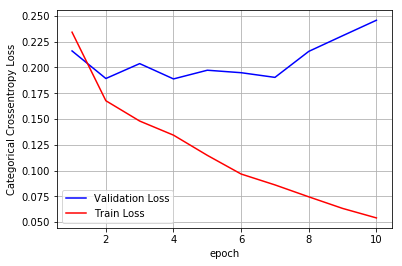

In [29]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x = list(range(1,epochs+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

#### There is differnece b/w training and test loss just because we have only used 100k datapoints and only taken 5000 top words this result can improve if we take more data and more top words but then it will take more time

## Conclusion

* Instead of Using Word2Vec or TF_IDF we have converted the text into vectors of Word Frequency Rank 
* Test Accuracy of the 2 Architectures are nearly same 
* But in both architecture we can see that Training Loss is much smaller than Test Loss which shows Overfitting but we can overcome this situation by using more data as we have only used 100k data and also by taking more top words as here we have only used 5000 Top Words
* Accuracy Increases slightly when we added one more LSTM Layer 



In [1]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = [ "No.LSTM_Layers",'No.LSTM_Units','Dropout_Rates','Training_Loss','Test_Accuracy']

In [2]:
x.add_row(['1','[100]','[0.25]','0.62','92.02%'])
x.add_row(['2','[100,100]','[0.35,0.25]','0.54','92.79%'])
print(x)

+----------------+---------------+---------------+---------------+---------------+
| No.LSTM_Layers | No.LSTM_Units | Dropout_Rates | Training_Loss | Test_Accuracy |
+----------------+---------------+---------------+---------------+---------------+
|       1        |     [100]     |     [0.25]    |      0.62     |     92.02%    |
|       2        |   [100,100]   |  [0.35,0.25]  |      0.54     |     92.79%    |
+----------------+---------------+---------------+---------------+---------------+
